2018 Edition

# Building a music recommender system

As its name implies, a recommender system is a tool that helps predicting what a user may or may not like among a list of given items. In some sense, you can view this as an alternative to content search, as recommendation engines help users discover products or content that they may not come across otherwise. For example, Facebook suggests friends and pages to users. Youtube recommends videos which users may be interested in. Amazon suggests the products which users may need... Recommendation engines engage users to services, can be seen as a revenue optimization process, and in general help maintaining interest in a service.

In this notebook, we study how to build a simple recommender system: we focus on music recommendations, and we use a simple algorithm to predict which items users might like, that is called ALS, alternating least squares.

## Goals

In this lecture, we expect students to:

- Revisit (or learn) recommender algorithms

- Understand the idea of Matrix Factorization and the ALS algorithm (serial and parallel versions)

- Build a simple model for a real usecase: music recommender system

- Understand how to validate the results

## Steps

We assume students to work outside lab hours on the learning material. These are the steps by which we guide students, during labs, to build a good basis for the end-to-end development of a recommender system:

* Inspect the data using Spark SQL, and build some basic, but very valuable knowledge about the information we have at hand
* Formally define what is a sensible algorithm to achieve our goal: given the "history" of user taste for music, recommend new music to discover. Essentialy, we want to build a statistical model of user preferences such that we can use it to "predict" which additional music the user could like
* With our formal definition at hand, we will learn different ways to implement such an algorithm. Our goal here is to illustrate what are the difficulties to overcome when implementing a (parallel) algorithm
* Finally, we will focus on an existing implementation, available in the Apache Spark MLLib, which we will use out of the box to build a reliable statistical model

Now, you may think at this point we will be done!

Well, you'd better think twice: one important topic we will cover in all our Notebooks is **how to validate the results we obtain**, and **how to choose good parameters to train models** especially when using an "opaque" library for doing the job. As a consequence, we will focus on the statistical validation of our recommender system.


# 1. Data

Understanding data is one of the most important part when designing any machine learning algorithm. In this notebook, we will use a data set published by Audioscrobbler - a music recommendation system for last.fm. Audioscrobbler is also one of the first internet streaming radio sites, founded in 2002. It provided an open API for “scrobbling”, or recording listeners’ plays of artists’ songs. last.fm used this information to build a powerful music recommender engine.

## 1.1. Data schema

Unlike a rating dataset which contains information about users' preference for products (one star, 3 stars, and so on), the datasets from Audioscrobbler only has information about events: specifically, it keeps track of how many times a user played songs of a given artist and the names of artists. That means it carries less information than a rating: in the literature, this is called explicit vs. implicit ratings.

### Reading material

- [Implicit Feedback for Inferring User Preference: A Bibliography](http://people.csail.mit.edu/teevan/work/publications/papers/sigir-forum03.pdf)
- [Comparing explicit and implicit feedback techniques for web retrieval: TREC-10 interactive track report](http://trec.nist.gov/pubs/trec10/papers/glasgow.pdf)
- [Probabilistic Models for Data Combination in Recommender Systems](http://mlg.eng.cam.ac.uk/pub/pdf/WilGha08.pdf)

The data we use in this Notebook is available in 3 files (these files are stored in our HDFS layer, in the directory  ```/datasets/lastfm```):

- **`user_artist_data.txt`**: It contains about 140,000+ unique users, and 1.6 million unique artists. About 24.2 million users’ plays of artists’ are recorded, along with their count. It has 3 columns separated by spaces: 

| UserID | ArtistID | PlayCount |
|----|----|----|
| ...|...|...|


- **`artist_data.txt`** : It prodives the names of each artist by their IDs. It has 2 columns separated by tab characters (`\t`).

| ArtistID | Name |
|---|---|
|...|...|

- **`artist_alias.txt`**: Note that when plays are scrobbled, the client application submits the name of the artist being played. This name could be misspelled or nonstandard. For example, "The Smiths", "Smiths, The", and "the smiths" may appear as distinct artist IDs in the data set, even though they are plainly the same. `artist_alias.txt` maps artist IDs that are known misspellings or variants to the canonical ID of that artist. The data in this file has 2 columns separated by tab characters (`\t`).

| MisspelledArtistID | StandardArtistID |
|---|---|
|...|...|



## 1.2. Understanding data: simple descriptive statistic

In order to choose or design a suitable algorithm for achieving our goals, given the data we have, we should first understand data characteristics. To start, we import the necessary packages to work with regular expressions, Data Frames, and other nice features of our programming environment.

In [22]:
import os
import sys
import re
import random
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time
import seaborn as sns

sqlContext = SQLContext(sc)
base = "/datasets/lastfm/"

<div class="alert alert-success">
    <p>We decided to use the <code>pandas</code> module to display some of our results, because we thought it was better at presenting data than the built-in functions.</p>
    <p>However, we do not use it for computations as it is much slower than the built-in and <code>pyspark</code> functions.</p>
</div>

### Question 1

#### Question 1.0 (Non-grading)
<div class="alert alert-info">
Using SPARK SQL, load data from `/datasets/lastfm/user_artist_data.txt` and show the first 20 entries (via function `show()`).
</div>

For this Notebook, from a programming point of view, we are given the schema for the data we use, which is as follows:

```
userID: long int
artistID: long int
playCount: int
```

Each line of the dataset contains the above three fields, separated by a "white space".

In [23]:
userArtistDataSchema = StructType([ \
    StructField("userID", LongType(), True), \
    StructField("artistID", LongType(), True), \
    StructField("playCount", IntegerType(), True)])

userArtistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter=' ') \
    .load(base + "user_artist_data.txt", schema = userArtistDataSchema) \
    .cache()

# we can cache an Dataframe to avoid computing it from the beginning everytime it is accessed.
userArtistDF.cache()

userArtistDF.show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



<div class="alert alert-success">
    <p>Just by looking at this table, we can see that for a given user (<code>userID=1000002</code> in the table above) there are artists that are way more popular than some others. Some artists have a <code>playcount</code> value of 1 or 2, which could mean that the user only tried one song from that artist and decided not to listen to that artist anymore. In that case, as we will see later on, it could be interesting to discard those rows.</p>
</div>

#### Question 1.1: 
<div class="alert alert-info">
How many distinct users do we have in our data? 
</div>

In [24]:
uniqueUsers = userArtistDF.select('userID').distinct().count()
print("Total number of users: ", uniqueUsers)

Total number of users:  148111


#### Question 1.2
<div class="alert alert-info">
How many distinct artists do we have in our data ?
</div>

In [25]:
uniqueArtists = userArtistDF.select('artistID').distinct().count()
print("Total number of artists: ", uniqueArtists)

Total number of artists:  1631028


#### Question 1.3
<div class="alert alert-info">
One limitation of Spark MLlib's ALS implementation - which we will use later - is that it requires IDs for users and items to be nonnegative 32-bit integers. This means that IDs larger than `Integer.MAX_VALUE`, or `2147483647`, can't be used. So we need to check whether this data set conforms to the strict requirements of our library.  

What are the maximum and minimum values of column `userID` ?  
</div>

In [26]:

display(userArtistDF.select('userID').describe().toPandas())


,summary,userID
0,count,24296858
1,mean,1947573.2653533637
2,stddev,496000.5551819132
3,min,90
4,max,2443548


<div class="alert alert-success">
    <p>The maximum <code>userID</code> value being <code>2,443,548</code>, we can assume that our dataset conforms to the library requirements.</p>
</div>

#### Question 1.4
<div class="alert alert-info">
What is the maximum and minimum values of column `artistID` ?
</div>

In [27]:

display(userArtistDF.select('artistID').describe().toPandas())


,summary,artistID
0,count,24296858
1,mean,1718704.0937568964
2,stddev,2539389.0924283555
3,min,1
4,max,10794401


We just discovered that we have a total of 148,111 users in our dataset. Similarly, we have a total of 1,631,028 artists in our dataset. The maximum values of `userID` and `artistID` are still smaller than the biggest number of integer type.  No additional transformation will be necessary to use these IDs.

One thing we can see here is that SPARK SQL provides very concise and powerful methods for data analytics (compared to using RDD and their low-level API). You can see more examples [here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).

Next, we might want to understand better user activity and artist popularity.

Here is a list of simple descriptive queries that helps us reaching these purposes:

* How many times each user has played a song? This is a good indicator of who are the most active users of our service. Note that a very active user with many play counts does not necessarily mean that the user is also "curious"! Indeed, she could have played the same song several times.
* How many play counts for each artist? This is a good indicator of the artist popularity. Since we do not have time information associated to our data, we can only build a, e.g., top-10 ranking of the most popular artists in the dataset. Later in the notebook, we will learn that our dataset has a very "loose" definition about artists: very often artist IDs point to song titles as well. This means we have to be careful when establishing popular artists. Indeed, artists whose data is "well formed" will have the correct number of play counts associated to them. Instead, artists that appear mixed with song titles may see their play counts "diluted" across their songs.

### Question 2

#### Question 2.1
<div class="alert alert-info">
How many times each user has played a song? Show 5 samples of the result.
</div>

In [28]:
userActivity = userArtistDF.groupBy('userID').sum("playCount").collect()

User with ID 2289066 has played 51 times a song.
User with ID 2289173 has played 5938 times a song.
User with ID 2290086 has played 1080 times a song.
User with ID 2291343 has played 37 times a song.
User with ID 2291463 has played 8802 times a song.



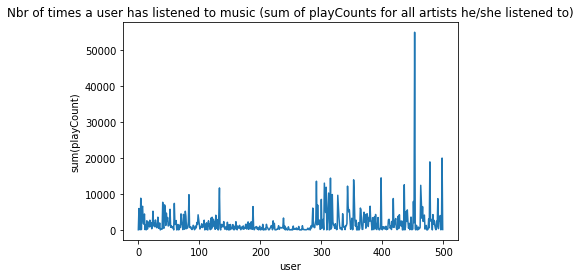

In [29]:
tmp = userActivity[:500]
for row in tmp[:5]:
    print('User with ID {} has played {} times a song.'.format(row[0], row[1]))
print()
plt.plot(range(len(tmp)), [row[1] for row in tmp])
plt.xlabel('user')
plt.ylabel('sum(playCount)')
plt.title('Nbr of times a user has listened to music (sum of playCounts for all artists he/she listened to)')
plt.show()

<div class="alert alert-success">
    <p>We can see here than we have fairly heterogeneous values for users' total <code>playCounts</code>. This is something that we will need to take into consideration when cleaning our dataset then when building our recommendation models.</p>  
</div>

#### Question 2.2
<div class="alert alert-info">
Plot CDF (or ECDF) of the number of play counts per User ID.  

Explain and comment the figure you just created:   
<ul>
<li>for example, look at important percentiles (25%, median, 75%, tails such as >90%) and cross check with what you have found above to figure out if the result is plausible. </li>
<li>discuss about your users, with respect to the application domain we target in the notebook: you will notice that for some users, there is very little interaction with the system, which means that maybe reccommending something to them is going to be more difficult than for other users who interact more with the system. </li>
<li>look at outliers and reason about their impact on your reccommender algorithm</li>
</ul>
</div>

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


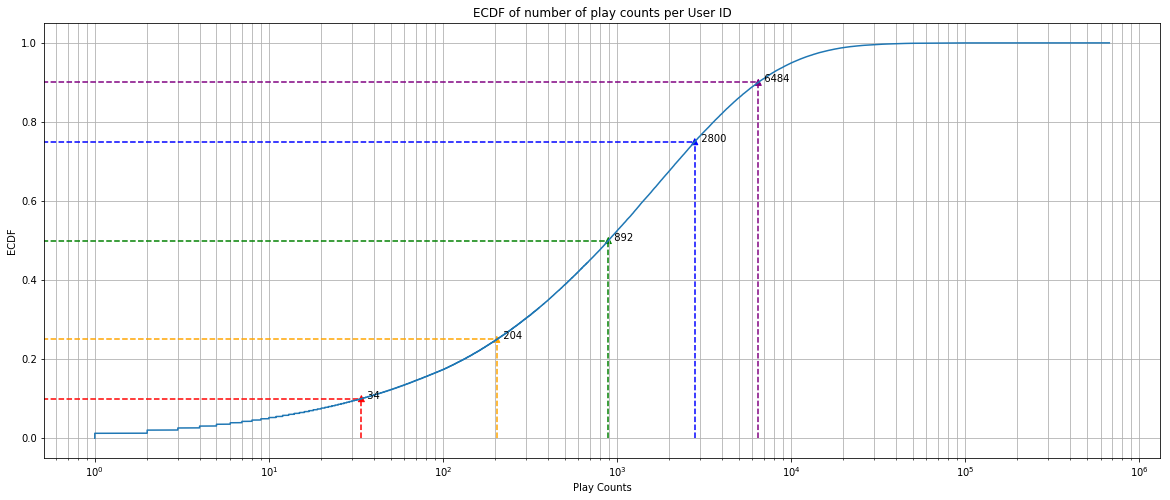

In [30]:

pdf = pd.DataFrame(data=userActivity)
Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))

l=[0.1,0.25,0.5,0.75,0.9, 1]

percentilesVals = [[Y[i] for i in range(len(Y)) if l[j]<yvals[i]<l[j+1]][0] for j in [0, 1, 2, 3, 4]]
percentilesValsy=[[yvals[i] for i in range(len(Y)) if l[j]<yvals[i]<l[j+1]][0] for j in [0, 1, 2, 3, 4] ]
colors = [ 'red', 'orange', 'green', 'blue', 'purple']

plt.figure(figsize=(20, 8))
plt.plot( Y, yvals )
ax = plt.subplot()
ax.set_xscale("log")

plt.scatter(percentilesVals,
            percentilesValsy, 
            c = colors,
            marker = '^')

ax.vlines(percentilesVals, [0], percentilesValsy, linestyle="dashed", color=colors)
ax.hlines(percentilesValsy, [0], percentilesVals, linestyle="dashed", color=colors)
for i in range(len(percentilesValsy)):
    ax.annotate("  " + str(percentilesVals[i]), (percentilesVals[i], percentilesValsy[i]))

plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.xscale('log')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per User ID')
plt.show()


<div class="alert alert-success">
    <p>This plot goes with what we were thinking when looking at the <code>sum(playCount)</code> for all users, which was that we have some users who listen to way more music than some others. The bottom 10% has listened to music on the platform 34 times or less, which is very little compared to common statistics.</p>
    <p>According to Spotify, the average user listened to around 40 unique artists per week in 2017, which is already above our value of 34 songs for 10% of our dataset. Even though our dataset is older, and our music platform is not Spotify, we can still assume that a good percentage of our users may not be as useful to our models than the main majority. We will see later on if we can consider them as noise.</p>
    <p>The same thinking process can be applied to the top 0.5%, whose <code>sum(playCount)</code> scores are above 40,000, which represents almost 2,500 hours of listening music (for an average time of 3'30" per song), which means about 3 months of music. These values are quite high (and only corresponding to a small fraction of our dataset), and can represent bots or people who have not turned off their listening devices. Either way, we might be able to improve our models by considering them like irrelevant users in our dataset.</p>
</div>

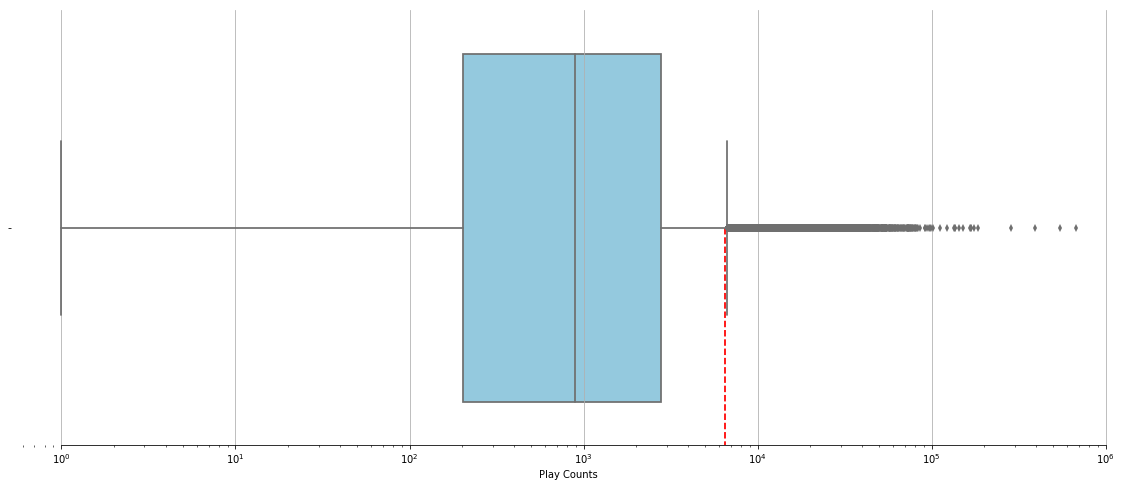

In [31]:
#horizontal boxplot
import seaborn as sns
f, ax = plt.subplots(figsize=(20, 8))
sns.set(style="whitegrid")

ax = sns.boxplot(Y, color="skyblue")
plt.xlabel('Play Counts')
ax.set_xscale("log")
ax.xaxis.grid(True)
ax.vlines(percentilesVals[-1], 0, 1, linestyle="dashed", color="red")
ax.set(ylabel="")
sns.despine(trim=True, left=True)


In [32]:
print('Total number of users:', len(Y))
l = len([y for y in Y if y>7000])
print('Number of users whose total playCounts are >7000: {}, which represents {}% of our dataset'.format(l, np.round(100.*(l/len(Y)))))

Total number of users: 148111
Number of users whose total playCounts are >7000: 13327, which represents 9.0% of our dataset


<div class="alert alert-success">
    <p>We can see here that there are a lot of outliers (after 7000 play count). If we keep on the idea that we had when looking at the previous plot, we can even go further here by saying that all of those users are like noise to our data and are therefore irrevelant to our recommendation models (which we will try to exploit at the end of this notebook). An explication for those users is that some people never turn off their music application even if they are not listening. Moreover we can also imagine that some might have been used to play some music in order to pull those songs up the rankings.</p>
    <p>Thus, when we will try to clean up our dataset, we could be able to consider almost 10% of the users as not relevant. We will see this at the end of the notebook.</p>
</div>

#### Question 2.3

<div class="alert alert-info">
How many play counts for each artist? Plot CDF or ECDF of the result.  

Similarly to the previous question, you need to comment and interpret your result: what is the figure telling you?
</div>

In [33]:
# Compute artist popularity
# We are interested in how many playcounts per artist
# ATTENTION! Grouping by artistID may be problematic, as stated above.

artistPopularity = userArtistDF.groupBy('artistID').sum("playCount").collect()


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


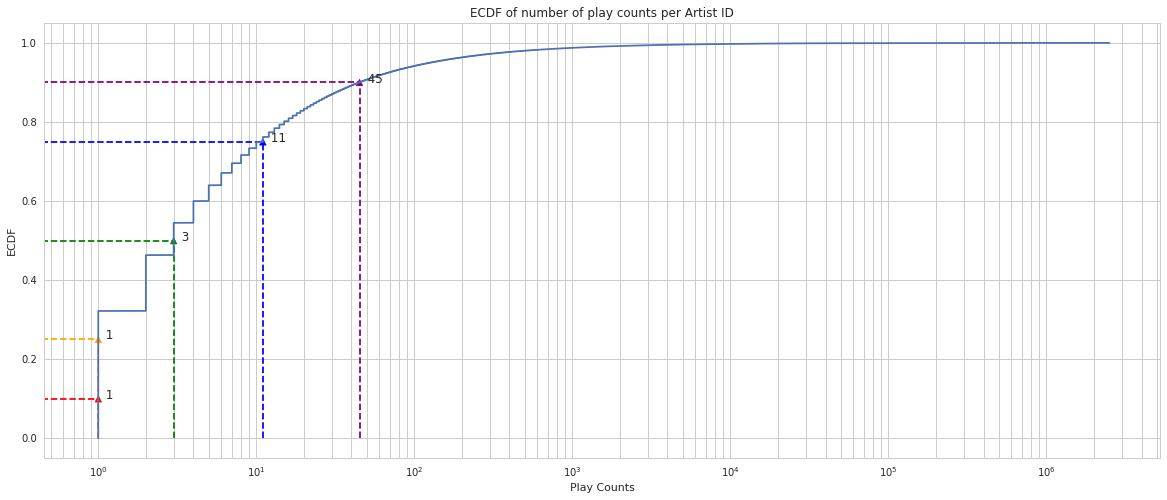

In [34]:

pdf = pd.DataFrame(data=artistPopularity)

Y=np.sort( pdf[1] )
yvals=np.arange(len(Y))/float(len(Y))


l=[0.1,0.25,0.5,0.75,0.9, 1]

percentilesVals_artist = [[Y[i] for i in range(len(Y)) if l[j]<yvals[i]<l[j+1]][0] for j in [0, 1, 2, 3, 4]]
percentilesValsy_artist=[[yvals[i] for i in range(len(Y)) if l[j]<yvals[i]<l[j+1]][0] for j in [0, 1, 2, 3, 4] ]

colors = [ 'red', 'orange', 'green', 'blue', 'purple']

plt.figure(figsize=(20, 8))
plt.plot( Y, yvals )
ax = plt.subplot()
ax.set_xscale("log")

plt.scatter(percentilesVals_artist,
            percentilesValsy_artist, 
            c = colors,
            marker = '^')

ax.vlines(percentilesVals_artist, [0], percentilesValsy_artist, linestyle="dashed", color=colors)
ax.hlines(percentilesValsy_artist, [0], percentilesVals_artist, linestyle="dashed", color=colors)
for i in range(len(percentilesValsy_artist)):
    ax.annotate("  " + str(percentilesVals_artist[i]), (percentilesVals_artist[i], percentilesValsy_artist[i]))

plt.xlabel('Play Counts')
plt.ylabel('ECDF')
plt.xscale('log')
plt.grid(True,which="both",ls="-")
plt.title('ECDF of number of play counts per Artist ID')
plt.show()


<div class="alert alert-success">
    <p>When looking at the users' <code>sum(playCount)</code> scores, we noted how some of them could be defined as <i>outliers</i> because their scores were so far away from the rest. This concept can be applied even more here: more than 50% of artists have been listened to three times or less, with more than 25% with only once. These are very surprising low values so we can either conclude that there are issues with the dataset (which we will see later) or that most of these artists are useless for building our models. Indeed, we will build our models on artists that are liked by the users (i.e. artists that are listened to <i>a lot</i> (which is very relative) by users), therefore we will need the artists that have relatively high <code>playCounts</code>.</p>
    <p>We will see at the end of the notebook how we can use this idea to discard a lot of artists and improve our models (and compute them much faster as well).</p>
    <p>Moreover, as we will see in the next section, some different <code>artistIDs</code> are refering to the same artist, which will help us explain why some <code>artistIDs</code> have such lower <code>playCount</code> scores.</p>
</div>

In [35]:
percentilesVals_artist[-1]

45

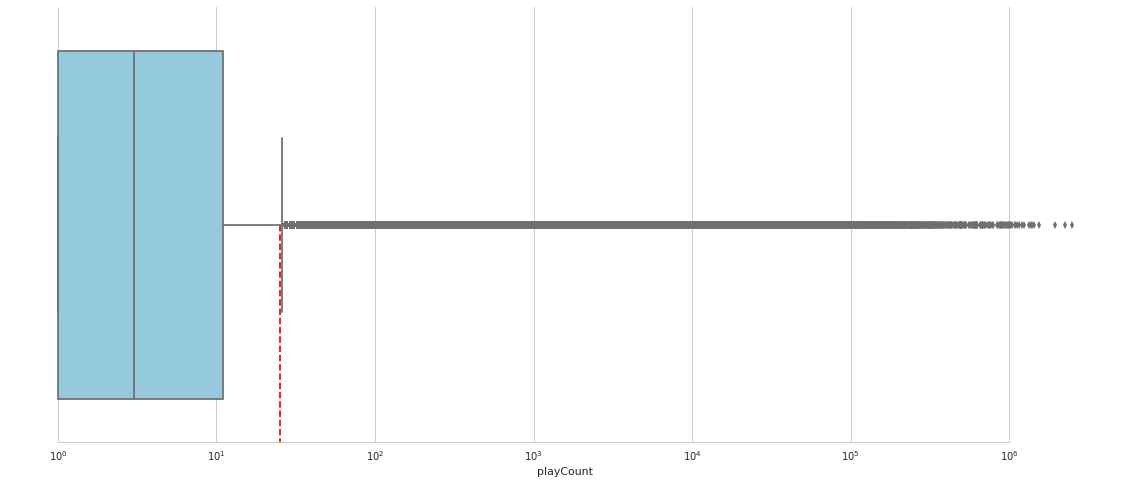

In [36]:
#horizontal boxplot
import seaborn as sns
f, ax = plt.subplots(figsize=(20, 8))
sns.set(style="whitegrid")

ax = sns.boxplot(Y, color="skyblue")
ax.set_xscale("log")
ax.xaxis.grid(True)
plt.xlabel('playCount')
ax.vlines(25, 0, 1, linestyle="dashed", color="red")
ax.set(ylabel="")
sns.despine(trim=True, left=True)

<div class="alert alert-success">
    <p>Here, we can see that there are also a lot of artists that stand after the limit of the bow plot. <strong>However</strong>, those artist are more important because they've been listened to a lot of times, which means that they are popular. On the opposite, many artist have a <code>playCount</code> really low (lower than 3 for 50% of the artists as we saw on the previous graph).</p>
    <p>There are a lot of reasons to that:
        <ul>
            <li>Their names are mispelled.</li>
            <li>A featuring which is not linked to the artists. (<i>artist_1</i> ft. <i>artist_2</i> might be linked to neither <i>artist_1</i> nor <i>artist_2</i>)</li>
            <li>Their names do make any sense (special characters, wrong format because the name is from a foreign languages, ...)</li>
        </ul>
    </p>
    <p>For the previous remarks, a sample of the dataset and some examples are provided right under this cell, where we can observe:
        <ul>
            <li>the mispelled names: <i>07 Shakespear's Sister</i></li>
            <li>the featurings which cannot be linked to more than one artist (if not none): <i>jus allah ft mr lif</i></li>
            <li>the random names that do not make sense: <i>7 nov 2004</i></li>
        </ul>
    </p>
    <p>And these artists do not have a good influence on our model: indeed, as we discussed, a lot of them have a <code>playCount</code> under 3 (arbitrary limit), which means that there is likely only person listened them. Thus they can't be use to suggest another music and, as there name is probably mispelled, they should not be suggested to anyone else.
    </p>
</ul>
</div>

In [37]:
#artistDF need to be defined before executing this script
i=0
l=[]
u=0
while i<20:
    if pdf[1][u]==1:
        l.append(pdf[0][u])
        u+=1
        i+=1
    else:
        u+=1
name=[]
for id in l:
    name.append(artistDF[artistDF.artistID==int(id)].collect()[0][1])
name

['Sander B',
 'YleX - Whigfield',
 'Xzibit Feat. Eminem and Nate Dogg',
 'Papa Tank (Opac Mass)',
 'The Butchers Orchestra',
 'Doctor Who - Jon Pertwee',
 'The Manhattan Transfer - The Manhattan Transfer',
 '�Ź�“�_�[�X',
 'richard linda thompson',
 'what good am i',
 'The Perry Weissman 3',
 'Gundecha Brothers',
 'Divers Klassiek',
 'Pantera/Pantera',
 'kayTies',
 'Dj Osman vs Celik',
 'Paul McCartney & Wings; Tony Visconti',
 'The Christians, Holly Johnson, Paul McCartney, Gerry Marsden & Stock Aitken Waterman',
 'FMwS - 08',
 'Kimi no chimeiteki ketsu betsu doutai']

#### Question 2.4
<div class="alert alert-info">
Plot a bar chart to show top 5 artists In terms of absolute play counts.  

Comment the figure you just obtained: 
<ul>
<li>are these reasonable results?</li>
<li>is looking at top-5 artists enough to learn more about your data?</li>
<li>do you see anything strange in the data?</li>
</ul>
</div>

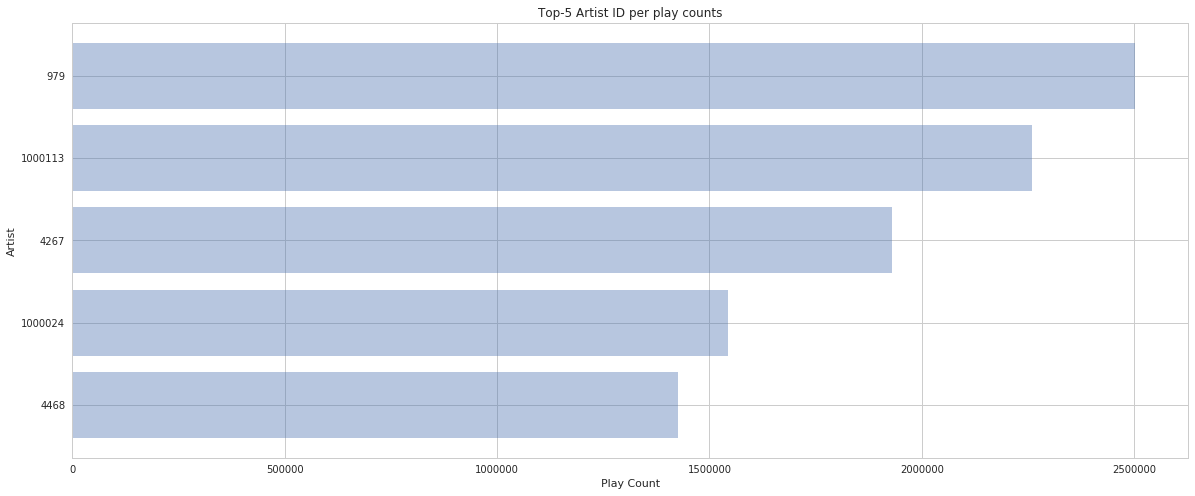

In [38]:

sortedArtist = sorted(artistPopularity, key = lambda x: -x[-1])[:5]

artistID = [w[0] for w in sortedArtist[:]]

y_pos = range(len(sortedArtist))
frequency = [w[1] for w in sortedArtist]
plt.figure(figsize=(20, 8))
plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, artistID[::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-5 Artist ID per play counts')
plt.show()


<div class="alert alert-success">
    <p>Our best artist has an absolute <code>playCount</code> of 2.5 millions. Let us compare this value to some other numbers that we were able to find:
        <ul>
            <li>Best artist (Ed Sheeran) on Spotify was streamed 6.3 billion times on Spotify over the year 2017.</li>
            <li>Spotify got 20 million new suscribers in 2017.</li>
            <li>During 2017, the average weekly listening hours per user grew by 25%.</li>
            <li>There were approximately 160 million active users using Spotify in January 2018.</li>
        </ul>
    </p>
    <p>Those numbers are way more recent that our dataset, which is from 2005, but they do show how fast the online music industry is moving. If we consider the low number of users streaming music on Internet then (around 150,000 on <i>Last.fm</i>), it does seem plausible that this value of 2.5 millions is the right <code>playCount</code> value for user 979.</p>
    <p>We lack information on our dataset as we could not find out if the data was for the year 2005 or for all of the three years <i>Last.fm</i> was running (the service started in 2002). If we consider that the dataset corresponds to the year 2005, we have a best score of 2.5 millions for 150,000 users. If we look at Spotify, we have 160 million users for a best score of 6.2 billions. While the number of users increased by a factor of 1000, the best score would have increased by a factor of 2500, which seems plausible.</p> 
</div>

All seems clear right now, but ... wait a second! What about the problems indicated above about artist "disambiguation"? Are these artist ID we are using referring to unique artists? How can we make sure that such "opaque" identifiers point to different bands? Let's try to use some additional dataset to answer this question:  `artist_data.txt` dataset. This time, the schema of the dataset consists in:

```
artist ID: long int
name: string
```

We will try to find whether a single artist has two different IDs.

### Question 3

#### Question 3.1

<div class="alert alert-info">
Load the data from `/datasets/lastfm/artist_data.txt` and use the SparkSQL API to show 5 samples.  

<ul></ul>
<div class="label label-success">HINT:</div> If you encounter some error when parsing lines in data because of invalid entries, parameter `mode='DROPMALFORMED'` will help you to eliminate these entries. The suggested syntax is: `<df>.options(header='false', delimiter='\t', mode='DROPMALFORMED')`.

</div>

In [39]:

customSchemaArtist = StructType([ \
    StructField("artistID", LongType(), True), \
    StructField("name", StringType(), True)])

artistDF = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + "artist_data.txt", schema = customSchemaArtist) \
    .cache()
    
display(artistDF.toPandas().head())


,artistID,name
0,1134999,06Crazy Life
1,6821360,Pang Nakarin
2,10113088,"Terfel, Bartoli- Mozart: Don"
3,10151459,The Flaming Sidebur
4,6826647,Bodenstandig 3000


#### Question 3.2
<div class="alert alert-info">
Find 20 artists whose name contains `Aerosmith`. Take a look at artists that have ID equal to `1000010` and `2082323`. In your opinion, are they pointing to the same artist?  

<ul></ul>
<div class="label label-success">HINT:</div> Function `locate(sub_string, string)` can be useful in this case.
</div>

In [40]:

# get artists whose name contains "Aerosmith"
display(artistDF[locate("Aerosmith", "name") > 0].toPandas().head(20))
print('There is at least %s times the word aerosmith' %( artistDF[locate("Aerosmith", "name") > 0].count()))
# show two examples
display(artistDF[artistDF.artistID==1000010].toPandas().head())
display(artistDF[artistDF.artistID==2082323].toPandas().head())


,artistID,name
0,10586006,Dusty Springfield/Aerosmith
1,6946007,Aerosmith/RunDMC
2,10475683,Aerosmith: Just Push Play
3,1083031,Aerosmith/ G n R
4,6872848,"Britney, Nsync, Nelly, Aerosmith,Mary J Blige."
5,10586963,Green Day - Oasis - Eminem - Aerosmith
6,10028830,The Aerosmith Antology2
7,10300357,Run-DMC + Aerosmith
8,2027746,Aerosmith by MusicInter.com
9,1140418,[rap]Run DMC and Aerosmith


There is at least 475 times the word aerosmith


,artistID,name
0,1000010,Aerosmith


,artistID,name
0,2082323,01 Aerosmith


<div class="alert alert-success">
    <p>As we expected from our results in the previous questions, we have several <code>artistIDs</code> corresponding to the same artist. Here, we have 475 <code>artistIDs</code> that point to Aerosmith. This can be due to users adding information to the artist's name (album, date, number) when uploading a song, or featurings where 'Aerosmith' is present. This highlights the necesity of cleaning our dataset before building recommendation models.</p>
    <p>The two examples that we display after the tables (<code>artistID=1000010</code> and <code>artistID=2082323</code>) show that we definetly have different <code>artistIDs</code> pointing to the same artist.</p>
    <p><strong>Moreover</strong>, we searched for the word 'Aerosmith' in our database, so our search excluded all of the mispelled names refering to Aerosmith.</p>
</div>

To answer this question correctly, we need to use an additional dataset `artist_alias.txt` which contains the ids of mispelled artists and standard artists. The schema of the dataset consists in:

```
mispelledID ID: long int
standard ID: long int
```

#### Question 3.3
<div class="alert alert-info">
Using SparkSQL API, load the dataset from `/datasets/lastfm/artist_alias.txt` then show 5 samples.
</div>

In [41]:

customSchemaArtistAlias = StructType([ \
    StructField( "mispelledID", LongType(), True ), \
    StructField( "standardID", LongType(), True)])

artistAliasDF = sqlContext.read \
.format('com.databricks.spark.csv') \
    .options(header='false', delimiter='\t', mode='DROPMALFORMED') \
    .load(base + "artist_alias.txt", schema = customSchemaArtistAlias) \
    .cache()

display(artistAliasDF.toPandas().head())

,mispelledID,standardID
0,1092764.0,1000311
1,1095122.0,1000557
2,6708070.0,1007267
3,10088054.0,1042317
4,1195917.0,1042317


#### Question 3.4
<div class="alert alert-info">
Verify the answer of question 3.2 ("Are artists that have ID equal to `1000010` and `2082323` the same ?") by finding the standard ids corresponding to the mispelled ids `1000010` and `2082323` respectively.
</div>

In [42]:
display(artistAliasDF[ artistAliasDF.mispelledID==1000010].toPandas().head(5))
print("Mispelled IDs corresponding to standardID 1000010: {}.\n".format(artistAliasDF[ artistAliasDF.standardID==1000010].sort(artistAliasDF.mispelledID).count()))
display(artistAliasDF[ artistAliasDF.mispelledID==2082323].toPandas().head())

,mispelledID,standardID


Mispelled IDs corresponding to standardID 1000010: 130.



,mispelledID,standardID
0,2082323,1000010


<div class="alert alert-success">
    <p>If we look for <code>mispelledID=2082323</code>, we get <code>1000010</code> as corresponding standardID, so they must point to the same artist.</p>
    <p>We can check that <code>1000010</code> is actually a <code>standardID</code> by looking for it in the <code>mispelledID</code> column, which proves us that it is not mispelled.</p>
    <p>Moreover, we can count the number of <code>mispelledIDs</code> that refer to <code>1000010</code>, and we get 130 as answer. This shows how many <code>artistIDs</code> from the original database could be mispelled and how important our next step is going to be. We can also argue that the mispelled database is not perfect so that we are probaly still missing some <code>mispelledIDs</code></p>
</div>

### Question 4

The mispelled or nonstandard information about artist make our results in the previous queries a bit "sloppy". To overcome this problem, we can replace all mispelled artist ids by the corresponding standard ids and re-compute the basic descriptive statistics on the "amended" data.
First, we construct a "dictionary" that maps non-standard ids to a standard ones. Then this "dictionary" will be used to replace the mispelled artists.

#### Question 4.1
<div class="alert alert-info">
From data in the dataframe loaded from `/datasets/lastfm/artist_alias.txt`, construct a dictionary that maps each non-standard id to its standard id.  

<div class="label label-success">HINT:</div> Instead of using function `collect`, we can use `collectAsMap` to convert the collected data to a dictionary inline.
</div>

In [43]:
artistAlias = artistAliasDF.rdd.map(lambda row: (row[0], row[1])).collectAsMap()

#### Question 4.2
<div class="alert alert-info">
Using the constructed dictionary in question 4.1, replace the non-standard artist ids in the dataframe that was loaded from `/datasets/lastfm/user_artist_data.txt` by the corresponding standard ids then show 5 samples.
</div>


**NOTE 1**: If an id doesn't exist in the dictionary as a mispelled id, it is really a standard id.


Using funtion `map` on Spark Dataframe will give us an RDD. We can convert this RDD back to Dataframe by using `sqlContext.createDataFrame(rdd_name, sql_schema)`


**NOTE 2**: be careful! you need to be able to verify that you indeed solved the problem of having bad artist IDs. In principle, for the new data to be correct, we should to have duplicate pairs (user, artist), potentially with different play counts, right? In answering the question, please **show** that you indeed fixed the problem. 

In [44]:
from time import time

def replaceMispelledIDs(fields):
    finalID = artistAlias.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(lambda row: replaceMispelledIDs(row)), 
    userArtistDataSchema
)
t1 = time()
print('The script takes %f seconds' %(t1-t0))

The script takes 0.732692 seconds


In [45]:
display(userArtistDF[userArtistDF.artistID==6708070].toPandas().head(20))
display(artistAliasDF[artistAliasDF.mispelledID==6708070].toPandas().head())
display(newUserArtistDF[newUserArtistDF.artistID==6708070].toPandas().head(20))

,userID,artistID,playCount
0,1006831,6708070,13
1,1034362,6708070,6
2,1044124,6708070,1
3,1060379,6708070,1
4,1068595,6708070,1
5,2009088,6708070,4
6,2054250,6708070,1
7,2061033,6708070,1
8,2062949,6708070,1
9,2073068,6708070,4


,mispelledID,standardID
0,6708070,1007267


,userID,artistID,playCount


<div class="alert alert-success">
    <p>To check if our replacement was successful, we decided to take a closer look at a <code>mispelledID</code> that we knew from a previous question. The first table shows how it was used aseveral times in the original dataset.</p>
    <p>In the second table, we map the <code>mispelledID</code> to its <code>standardID 1007267</code>.</p>
    <p>After cleaning up the data, we can see in the third table that there are no more <code>6708070</code> in the dataset (as expected), since it was replaced by its <code>standardID</code>.</p>
</div>

<div class="alert alert-success">
<h3>More digging into the artistAlias dataset</h3>
<p>We will use the <code>newUserArtistDF</code> dataframe in the following questions, but we would like to study a bit more the <code>artistAlias</code> dataset first.<p>
<p>Here is what we've found :</p>
<ul>
    <li>Some tuples (userID,artistID) are present more than one time in the data set.</li>
    <li>Some mispelled ID, point to another mispelled one.</li>
    <li>Some mispelled ID, which actually are not mispelled</li>
</ul>
</div>

In [46]:
duplicates=newUserArtistDF.groupBy("userID", "artistID").agg(count("playCount")).filter(col('count(playCount)')>1)
duplicates.limit(5).toPandas()

,userID,artistID,count(playCount)
0,2013279,2003588,3
1,2013595,1034635,2
2,2013661,1011031,2
3,2013712,1224254,2
4,2013976,1007712,2


<div class="alert alert-success">
<p>We can see that in the new data, we have duplicate pairs (user, artist), potentially with different play counts, which shows that the data had been cleaned up even further (they correspond to former <code>mispelledIDs</code>).. Those duplicates will be aggregated in optimisation part when we will remove the alias chain. <p>
</div>

In [47]:
# Count the number of mispelled ID that remap on mispelledID
standardID_col = artistAliasDF.select(artistAliasDF.standardID)
mispelledID_col = artistAliasDF.select(artistAliasDF.mispelledID)
Wrong_remaps = standardID_col.join(mispelledID_col, mispelledID_col.mispelledID==standardID_col.standardID, "inner").count()
print("There are %d mispelledID that remap on another mispelled ID" % (Wrong_remaps))
print("Here is some examples:")
display(standardID_col.join(mispelledID_col, mispelledID_col.mispelledID==standardID_col.standardID, "inner").toPandas().head(20))

There are 1139 mispelledID that remap on another mispelled ID
Here is some examples:


,standardID,mispelledID
0,1013851,1013851
1,1008798,1008798
2,1245218,1245218
3,1008798,1008798
4,1018110,1018110
5,1018110,1018110
6,1014609,1014609
7,1014609,1014609
8,1014175,1014175
9,1014175,1014175


In [48]:
absorbingAliasDF = artistAliasDF[artistAliasDF.mispelledID == artistAliasDF.standardID]
display(absorbingAliasDF.toPandas().head(10))

,mispelledID,standardID
0,1018110,1018110
1,1014609,1014609
2,1014175,1014175
3,1008798,1008798
4,1013851,1013851
5,1001864,1001864
6,15,15
7,1167860,1167860
8,754,754
9,1006322,1006322


<div class="alert alert-success">
<p>The first of these two tables show <code>artistIDs</code> that are in both standard and mispelled columns. The second table shows the few row that display the same ID for both mispelled and standard IDs.</p>
<p>We will look later on how to take these issues int consideration to clean up our datasets even further</p>
</div>

#### Question 4.3
<div class="alert alert-info">
Spark actions are executed through a set of stages, separated by distributed "shuffle" operations. Spark can be instructed to **automatically and efficiently** broadcast common data needed by tasks within **each stage**. The data broadcasted this way is cached in **serialized form** and deserialized before running each task.   
<ul> </ul>
We can thus improve our answer to question 4.2: we can reduce the communication cost by shipping the "dictionary" in a more efficient way by using `broadcast variable`. Broadcast variables allow the programmer to keep a read-only variable cached on **each machine** rather than shipping a copy of it with tasks. They are cached in deserialized form. They can be used, for example, to give every node a copy of a large input dataset in an efficient manner.   
<ul></ul>
The broadcast of variable `v` can be created by `bV = sc.broadcast(v)`. Then value of this broadcast variable can be access via `bV.value`  

<ul></ul>
To question is then: using a broadcast variable, modify the script in question 4.2 to get better performance in terms of running time.
</div>


In [49]:
from time import time

bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newUserArtistDF = sqlContext.createDataFrame(
    userArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)

t1 = time()
print('The script takes %f seconds' %(t1-t0)) # got 0.686447 in the previous question
newUserArtistDF = newUserArtistDF.cache()

newUserArtistDF.show()

The script takes 0.022605 seconds
+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000002|       1|       55|
|1000002| 1000006|       33|
|1000002| 1000007|        8|
|1000002| 1000009|      144|
|1000002| 1000010|      314|
|1000002| 1000013|        8|
|1000002| 1000014|       42|
|1000002| 1000017|       69|
|1000002| 1000024|      329|
|1000002| 1000025|        1|
|1000002| 1000028|       17|
|1000002| 1000031|       47|
|1000002| 1000033|       15|
|1000002| 1000042|        1|
|1000002| 1000045|        1|
|1000002| 1000054|        2|
|1000002| 1000055|       25|
|1000002| 1000056|        4|
|1000002| 1000059|        2|
|1000002| 1000062|       71|
+-------+--------+---------+
only showing top 20 rows



<div class="alert alert-success">
    <p>We are now doing the whole replacement process by broadcasting the <code>artistAlias</code> dataset to avoid sending/receiving it everytime: we expect a faster computation time.</p>
    <p>The computation is done in 51ms, while it was done in 685ms when the dataset was not broadcasted. So we improved our computation time by a factor of 12, which shows the potential of broadcast variable.</p>
</div>

In [50]:
display(userArtistDF[userArtistDF.artistID==6708070].toPandas().head(20))
display(artistAliasDF[artistAliasDF.mispelledID==6708070].toPandas().head(20))
display(newUserArtistDF[newUserArtistDF.artistID==6708070].toPandas().head(20))

,userID,artistID,playCount
0,1006831,6708070,13
1,1034362,6708070,6
2,1044124,6708070,1
3,1060379,6708070,1
4,1068595,6708070,1
5,2009088,6708070,4
6,2054250,6708070,1
7,2061033,6708070,1
8,2062949,6708070,1
9,2073068,6708070,4


,mispelledID,standardID
0,6708070,1007267


,userID,artistID,playCount


<div class="alert alert-success">
    <p>There again, we can check that our replacement of <code>mispelledID</code> was succesful as we did in the previous question:</p>
    <ul>
        <li>We see that a <code>mispelledID</code> is used in the original dataset,</li>
        <li>and that it is not longer present in the new one, as it was replaced by its corresponding <code>standardID</code>.</li>
    </ul>
</div>

Although having some advantages, explicitly creating broadcast variables is only useful when tasks across multiple stages need the same data or when caching the data in deserialized form is important.

### Question 5

Well, our data frame contains clean and "standard" data. We can use it to redo previous statistic queries.

#### Question 5.1
<div class="alert alert-info">
How many unique artists? Compare with the result when using old data.
</div>

In [51]:
uniqueArtists = newUserArtistDF.select(newUserArtistDF.artistID).distinct().count()
# we had 1,631,028
print("Total number of artists: ", uniqueArtists)

Total number of artists:  1568126


<div class="alert alert-success">
    <p>We initially had <code>1,631,028</code> artists in the original dataset. After cleaning up, we can expect much less.</p>
    <p>We now get <code>1,568,126</code> unique artists, which is less than the original value, even though we were expecting a bigger difference between the two values. Maybe more cleaning will allow us to remove even more artists. We will try to go further into cleaning up the data at the end of the notebook.</p>
</div>

#### Question 5.2

<div class="alert alert-info">
Who are the top-10 artistis?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "audience size", that is, how many users listened to one of their track at least once</li>
</ul>  

Plot the results, and explain the figures you obtain.
</div>

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


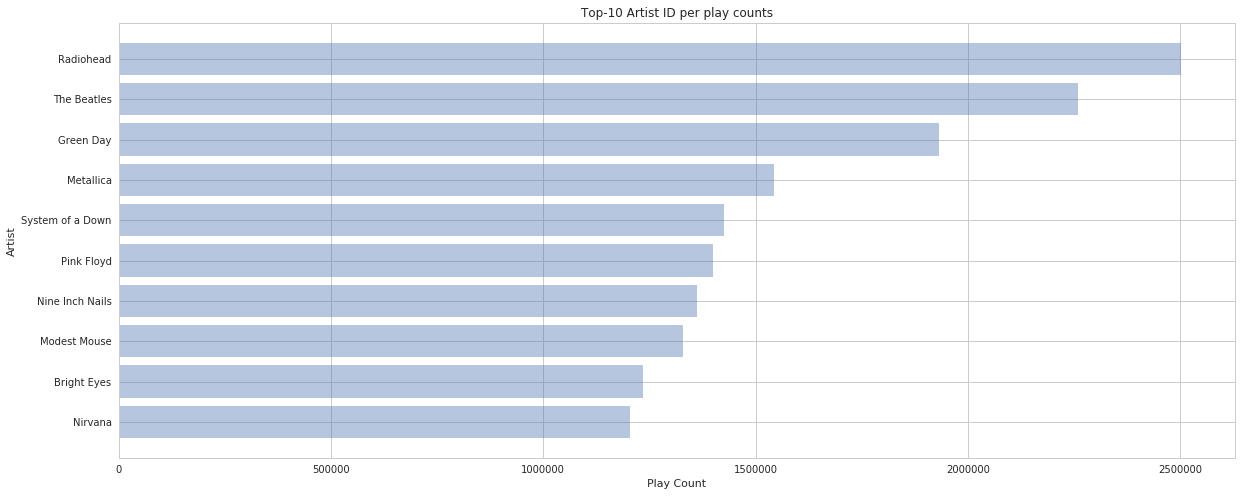

In [52]:
# calculate top-10 artists in term of play counts
top10ArtistsPC = newUserArtistDF.groupBy('artistID').sum('playCount').orderBy('sum(playCount)', ascending=0).take(10)

y_pos = range(len(top10ArtistsPC))
pdf = pd.DataFrame(data=top10ArtistsPC)
for i in range(len(pdf)):
    pdf[0][i]=artistDF[artistDF.artistID==int(pdf[0][i])].collect()[0][1]
plt.figure(figsize=(20, 8))
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Play Count')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per play counts')
plt.show()

<div class="alert alert-success">
    <p>Our first reaction is that we have the same top-5 as we had in Question 2.4.</p>
    <p>Moreover, now that we have the artits' names, we can quickly take a look at this top-10 and see that most of them are indeed what we'd expect from a top-10. This is a sign that our dataset and our computations are fairly right so far.</p>
    <p>Our five first artists did not gain much from the replacement process that we did on the dataset, since we seem to have the same values for <code>playCount</code> as we did before the replacement process.</p>
</div>

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


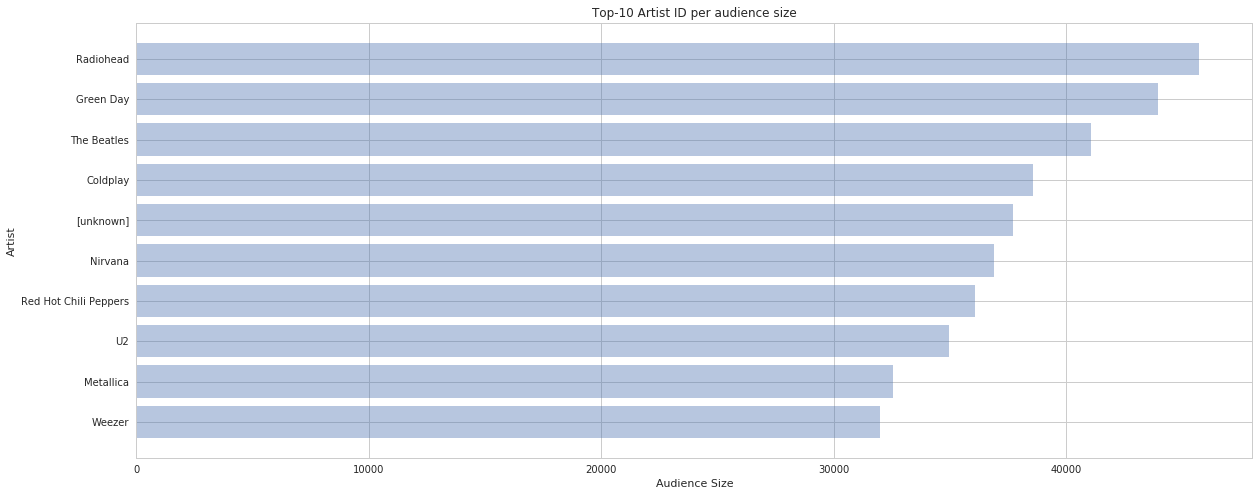

In [53]:
# calculate top-10 artists in term of audience size
top10ArtistsAS=newUserArtistDF.groupBy('artistID').agg(count('userID')).orderBy('count(userID)', ascending=0).take(10)

y_pos = range(len(top10ArtistsAS))
pdf = pd.DataFrame(data=top10ArtistsAS)
for i in range(len(pdf)):
    pdf[0][i]=artistDF[artistDF.artistID==int(pdf[0][i])].collect()[0][1]
plt.figure(figsize=(20, 8))
plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])
plt.xlabel('Audience Size')
plt.ylabel('Artist')
plt.title('Top-10 Artist ID per audience size')
plt.show()


<div class="alert alert-success">
    <p>We can compare this chart with the one we had when rating by <code>playCount</code>. We have more or less the same artists (the exact same top-3).</p>
    <p>We can deduce for the differences between theses two graphs that some artists might have more 'loyal' listeners than others, and that the others benefit from more advertising. For example, <i>System of a Down</i> is ranked 5th on the first graph, which means that its songs are very popular, but it does not appear on the second graph, which means that its audience is smaller in comparaison with the others: this could mean that its audience is smaller in size but listens to its songs more than a bigger audience does for another artist.</p>
</div>

In [54]:
display(artistDF[artistDF.name=='[unknown]'].toPandas().head())

,artistID,name
0,1034635,[unknown]


<div class="alert alert-success">
    <p>An interesting thing that we can see on that new chart is also that we have an <code>[unknown]</code> artist who gathers almost 40,000 users.</p>
    <p>Our explanation for this is that many songs and artists are merged into that one unknown entity that represents all of the unknown artists present in the database.</p>
    <p>Since this artist actually represents several other artists, we will not take it into consideration when building our models, and will make sure that we do not recommend it to users.</p>
    <p>But by deleting it, we loose a lot of information. We could solve this issue by giving each unknown artist (before they're all merged into one) an unused ID so that we could keep each unknown artist's data when building the models. We would still have to take them out of the recommendation lists.</p>
</div>

#### Question 5.3

<div class="alert alert-info">
Who are the top-10 users?
<ul>
  <li>In terms of absolute play counts</li>
  <li>In terms of "curiosity", that is, how many different artists they listened to</li>

</ul>  

Plot the results
</div>

In [55]:
def spendingtime(i,pdf):
    '''
        given a userID, this function computes the total time listening to music spent by that user 
    '''
    count=pdf[1][i]*3.3
    return(count)

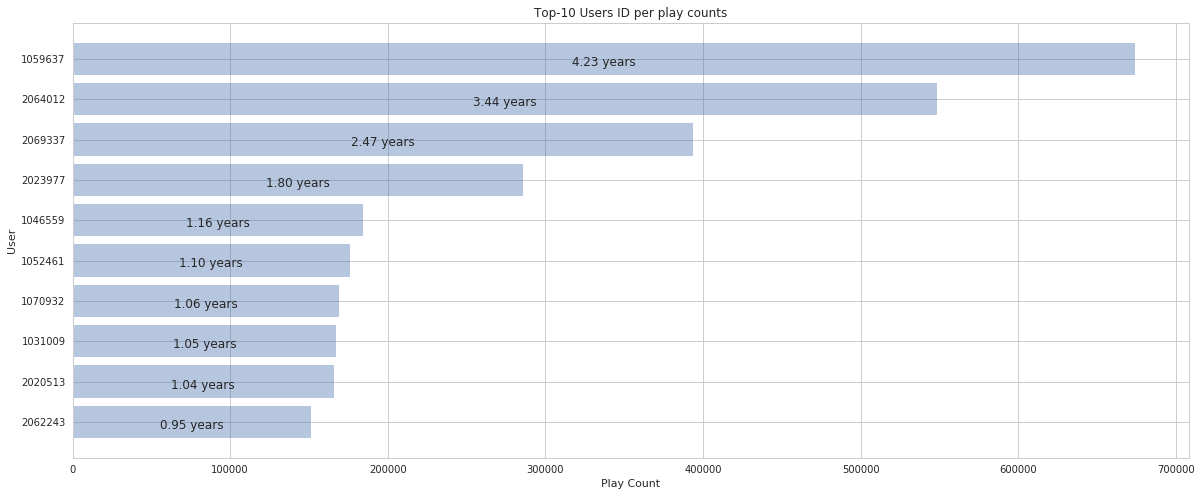

In [56]:
# calculate top 10 users interm of play counts
top10UsersByPlayCount = newUserArtistDF.groupBy('userID')\
                                        .sum('playCount')\
                                        .orderBy('sum(playCount)', ascending=0)\
                                        .take(10)
y_pos = range(len(top10UsersByPlayCount))
pdf = pd.DataFrame(data=top10UsersByPlayCount)
plt.figure(figsize=(20, 8))
bar=plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])

SpendingTimeslisteningmusic=["%.2f years" %(spendingtime(i,pdf)/(60*24*365)) for i in range(len(pdf))][::-1]
i=0
for rect in bar:
    width = rect.get_width()
    plt.text(width/2,rect.get_y() + rect.get_height()/5.0 , SpendingTimeslisteningmusic[i] , ha='center', va='bottom')
    i+=1

plt.xlabel('Play Count')
plt.ylabel('User')
plt.title('Top-10 Users ID per play counts')
plt.show()

<div class="alert alert-success">
    <p>What is interesting on this graph is that we can see that the top 4 users are way ahead of the rest, all of the following users having relatively the same <code>playCount</code>. The 1st user has a <code>playCount</code> value more than 3 times the value of the 5th user.</p>
    <p>One explanation for this is that the top users are not 'normal' users. This could mean that they are users who never turned off their music application, who shared their account credentials to other people and that there were several persons listening with a same account at the same time. If an account is used in a public place (shop, bar, ...), we can imagine that the application is on for quite a while (more than for a single person for example). Moreover, there could be bots 'listening' to music to increase <code>playCounts</code> for given artists/songs (but since the dataset is from 2005, this explanation is less plausible than if it was from nowadays). Finally, there could be errors in the datasets.</p>
    <p>Whatever the reason for those users might be, since the data is from 2005 and <i>Last.fm</i> started off in 2002, the first two users can be considered as irrelevant for our next computations since there is something off about them. We could extrapolate and take out the third and fourth users as well, since they seem way ahead of the rest as well.</p>
</div>


<div>
    <h3>Missing artist names</h3>
    <p>When computing the total time spend listening to music for a given user, we ran into errors. Debugging let us to find out that some <code>artistID</code> (present in the dataset) did not have an <code>artistName</code> associated to them.</p>
</div>

In [57]:
display(artistDF[artistDF.artistID==int(2187876)].toPandas().head())

,artistID,name


<div class="alert alert-success">
    <p>To keep on investigating this issue, let's compute how many artists are missing a name:</p>
</div>

In [58]:
count_total = newUserArtistDF.select('artistID').distinct().count()
newUserArtist_col = newUserArtistDF.select(newUserArtistDF.artistID).distinct()
artistID_col = artistDF.select(artistDF.artistID).distinct()
GoodArtist = newUserArtist_col.join(artistID_col, newUserArtist_col.artistID==artistID_col.artistID, "inner")
print("There is %s artistID with no name associated in the data Base" %(count_total - GoodArtist.count()))

There is 13966 artistID with no name associated in the data Base


<div class="alert alert-success">
    <p>So we have 13,966 artists whose names cannot be found in the <code>artistDF</code> dataset. Since they still have a valid <code>artistID</code>, we will still use them when building our recommendation models. However, we will not recommend them to users since we do not have their names.</p>
</div>

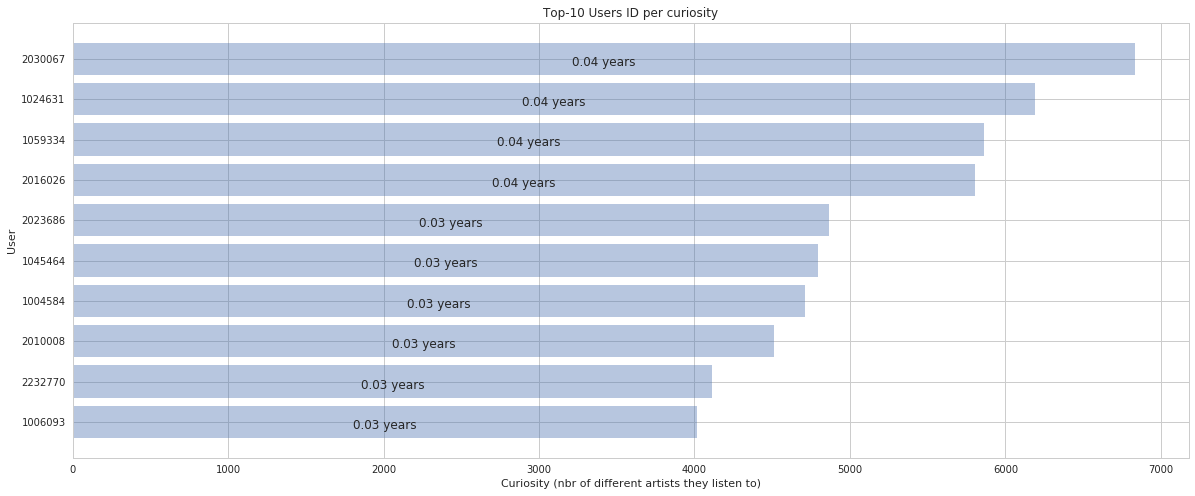

In [59]:
# calculate top 10 users interm of curiosity
top10UsersByCuriosity=newUserArtistDF.groupBy('userID').agg(count('artistID')).orderBy('count(artistID)', ascending=0).take(10)

y_pos = range(len(top10UsersByCuriosity))
pdf = pd.DataFrame(data=top10UsersByCuriosity)

plt.figure(figsize=(20, 8))
bar=plt.barh(y_pos, pdf[1][::-1], align='center', alpha=0.4)
plt.yticks(y_pos, pdf[0][::-1])

SpendingTimeslisteningmusic=["%.2f years" %(spendingtime(i,pdf)/(60*24*365)) for i in range(len(pdf))][::-1]
i=0
for rect in bar:
    width = rect.get_width()
    plt.text(width/2,rect.get_y() + rect.get_height()/5.0 , SpendingTimeslisteningmusic[i] , ha='center', va='bottom')
    i+=1

plt.xlabel('Curiosity (nbr of different artists they listen to)')
plt.ylabel('User')
plt.title('Top-10 Users ID per curiosity')
plt.show()

<div class='alert alert-success'>
    <p>If we rank the users by curiosity, we can see that our best users by <code>playCount</code> are not in this top-10.</p>
     <p>If we take a closer look at how much time they spend listening to music, we can see that they are way behind our other top users (ranked by <code>playCounts</code>), which again highlights how some users might listen (a lot) to the same artists. This could be something to take into consideration when recommending new artists/songs to users.</p>
<p>We will not go into the details of such an approach, but we could imagine recommendations that could be based on how <i>curious</i> a user is, or how <i>loyal</i> (or how not curious..) another one is, and recommend adapted artists/songs. For example, for a curious user, we will recommend new artists, while we might just recommend new songs from the same artists for a less curious user.</p>
    <p>This shows how ranking users by <code>playCount</code> can be misleading in our interpretation of the dataset.</p>
</div>


Now we have some valuable information about the data. It's the time to study how to build a statistical models.

# 2. Build a statistical models to make recommendations

## 2.1 Introduction to recommender systems

In a recommendation-system application there are two classes of entities, which we shall refer to as `users` and `items`. Users have preferences for certain items, and these preferences must be inferred from the data. The data itself is represented as a `preference matrix` $A$, giving for each user-item pair, a value that represents what is known about the degree of preference of that user for that item. The table below is an example for a `preference matrix` of 5 users and `k` items. The `preference matrix` is also known as `utility matrix`.

| | IT1 | IT2 | IT3 | ... | ITk |
|---|---|---|---|---|---|
| U1 | 1 |  | 5 | ... | 3 |
| U2 |  | 2 |  | ... | 2 |
| U3 | 5 |  | 3 | ... |  |
| U4 | 3 | 3 |  | ... | 4 |
| U5 |  | 1 |  | ... | ... |

The value of row i, column j expresses how much does user `i` like item `j`. The values are often the rating scores of users for items. An unknown value implies that we have no explicit information about the user's preference for the item. The goal of a recommendation system is to predict "the blanks" in the `preference matrix`. For example, assume that the rating score is from 1 (dislike) to 5 (love), would user `U5` like `IT3` ? We have two approaches:

* Designing our recommendation system to take into account properties of items such as brand, category, price... or even the similarity of their names. We can denote the similarity of items `IT2` and `IT3`, and then conclude that because user `U5` did not like `IT2`, they were unlikely to enjoy SW2 either.

* We might observe that the people who rated both `IT2` and `IT3` tended to give them similar ratings. Thus, we could conclude that user `U5` would also give `IT3` a low rating, similar to `U5`'s rating of `IT2`

It is not necessary to predict every blank entry in a `utility matrix`. Rather, it is only necessary to discover some entries in each row that are likely to be high. In most applications, the recommendation system does not oﬀer users a ranking of all items, but rather suggests a few that the user should value highly. It may not even be necessary to ﬁnd all items with the highest expected ratings, but only to ﬁnd a large subset of those with the highest ratings.


## 2.2 Families of recommender systems

In general, recommender systems can be categorized into two groups:

* **Content-Based** systems focus on properties of items. Similarity of items is determined by measuring the similarity in their properties.

* **Collaborative-Filtering** systems focus on the relationship between users and items. Similarity of items is determined by the similarity of the ratings of those items by the users who have rated both items.

In the usecase of this notebook, artists take the role of `items`, and `users` keep the same role as `users`.
Since we have no information about `artists`, except their names, we cannot build a `content-based` recommender system.

Therefore, in the rest of this notebook, we only focus on `Collaborative-Filtering` algorithms.

## 2.3 Collaborative-Filtering 
In this section, we study a member of a broad class of algorithms called `latent-factor` models. They try to explain observed interactions between large numbers of users and products through a relatively small number of unobserved, underlying reasons. It is analogous to explaining why millions of people buy a particular few of thousands of possible albums by describing users and albums in terms of tastes for perhaps tens of genres, tastes which are **not directly observable or given** as data. 

First, we formulate the learning problem as a matrix completion problem. Then, we will use a type of `matrix factorization` model to "fill in" the blanks.  We are given implicit ratings that users have given certain items (that is, the number of times they played a particular artist) and our goal is to predict their ratings for the rest of the items. Formally, if there are $n$ users and $m$ items, we are given an $n \times m$ matrix $R$ in which the generic entry $(u, i)$ represents the rating for item $i$ by user $u$. **Matrix $R$ has many missing entries indicating unobserved ratings, and our task is to estimate these unobserved ratings**.

A popular approach to the matrix completion problem is **matrix factorization**, where we want to "summarize" users and items with their **latent factors**.

### 2.3.1 Basic idea and an example of Matrix Factorization
For example, given a preference matrix 5x5 as below, we want to approximate this matrix into the product of two smaller matrixes $X$ and $Y$ .

$$
M = 
\begin{bmatrix}
 5 & 2 & 4 & 4 & 3 \\
 3 & 1 & 2 & 4 & 1 \\
 2 &  & 3 & 1 & 4 \\
 2 & 5 & 4 & 3 & 5 \\
 4 & 4 & 5 & 4 &  \\
\end{bmatrix}
\approx M^\prime =
\begin{bmatrix}
 x_{11} & x_{12} \\
 x_{21} & x_{22} \\
 x_{31} & x_{32} \\
 x_{41} & x_{42} \\
 x_{51} & x_{52} \\
\end{bmatrix}
\times
\begin{bmatrix}
 y_{11} & y_{12} & y_{13} & y_{14} & y_{15} \\
 y_{21} & y_{22} & y_{23} & y_{24} & y_{25} \\
\end{bmatrix}
$$

$M^\prime$ is an approximation that is as close to A as possible. To calculate how far from $M$ $M^\prime$ is, we often calculate the sum of squared distances of non-empty elements in $M$ and the corresponding elements in $M^\prime$.
In this way, for $M^\prime$, besides the approximated elements in $M$, we also have the non-observed elements. Therefore, to see how much does user `i` like item `j`, we simply pick up the value of $M^\prime_{i,j}$.

The challenge is how to calculate $X$ and $Y$. The bad news is that this can't be solved directly for both the best $X$ and best $Y$ at the same time. Fortunately, if $Y$ is known, we can calculate the best of $X$, and vice versa. It means from the initial values of $X$ and $Y$ in the beginning, we calculate the best $X$ according to $Y$, and then calculate the best $Y$ according to the new $X$. This process is repeated until the distance from $XY$ to $M$ is small. It's simple, right ?

Let's take an example. To compute the approximation for the above 5x5 matrix $M$, first, we initialize the value of $X$ and $Y$ as below.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

With the initial iteration, we calculate the the Root-Mean-Square Error from $XY$ to $M$.

Consider the ﬁrst rows of $M$ and $XY$ . We subtract the first row of $XY$ from the entries in the ﬁrst row of $M$, to get $3,0,2,2,1$. We square and sum these to get $18$. 

In the second row, we do the same to get $1,−1,0,2,−1$, square and sum to get $7$. 

In the third row, the second column is blank, so that entry is ignored when computing the RMSE. The diﬀerences are $0,1,−1,2$ and the sum of squares is $6$. 

For the fourth row, the diﬀerences are $0,3,2,1,3$ and the sum of squares is $23$. 

The ﬁfth row has a blank entry in the last column, so the diﬀerences are $2,2,3,2$ and the sum of squares is $21$. 

When we sum the sums from each of the ﬁve rows, we get $18+7+6+23+21 = 75$. So, $RMSE=\sqrt{75/23}=1.806$ where $23$ is the number of non-empty values in $M$.

Next, with the given value of $Y$, we calculate $X$ by finding the best value for $X_{11}$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 x & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 1 & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 x+1 & x+1 & x+1 & x+1 & x+1 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

Now, to minimize the $RMSE$  we minimize the difference of the first rows $(5−(x+1))^2 + (2−(x+1))^2 + (4−(x+1))^2 + (4−(x+1))^2 + (3−(x+1))^2$. By  taking the derivative and set that equal to 0, we pick $x=2.6$

Given the new value of $X$, we can calculate the best value for $Y$.

$$
M^\prime = X \times Y =
\begin{bmatrix}
 2.6 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
 1 & 1 \\
\end{bmatrix}
\times
\begin{bmatrix}
 y & 1 & 1 & 1 & 1 \\
 1 & 1 & 1 & 1 & 1 \\
\end{bmatrix}
=
\begin{bmatrix}
 3.6 & 3.6 & 3.6 & 3.6 & 3.6 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
 2 & 2 & 2 & 2 & 2 \\
\end{bmatrix}
$$

By doing the same process as before, we can pick value for $y=1.617$. After that, we can check if the $RMSE$ is not converged, we continue to update $X$ by $Y$ and vice versa. In this example, for simple, we only update one element of each matrix in each iteration. In practice, we can update a full row or full matrix at once.


### 2.3.2 Matrix Factorization: Objective and ALS Algorithm on a Single Machine

More formally, in general, we select $k$ latent features, and describe each user $u$ with a $k-$dimensional vector $x_u$, and each item $i$ with a $k-$dimensional vector $y_i$.

Then, to predict user $u$'s rating for item $i$, we do as follows: $ r_{ui} \approx x_{u}^{T}y_i$.

This can be put, more elegantly, in a matrix form. Let $x_1, \cdots x_n \in \mathbb{R}^k$ be the factors for the users, and $y_1, \cdots y_m \in \mathbb{R}^k$ the factors for the items. The $k \times n$ user matrix $X$ and the $k \times m$ item matrix $Y$ are then defined by:

$$
X = 
\begin{bmatrix}
 |   &         & |  \\
x_1  &  \cdots & x_n\\
 |   &         & |  \\
\end{bmatrix}
$$

$$
Y = 
\begin{bmatrix}
 |   &         & |  \\
y_1  &  \cdots & y_i\\
 |   &         & |  \\
\end{bmatrix}
$$

Our goal is to estimate the complete ratings matrix $R \approx X^{T} Y$. We can formulate this problem as an optimization problem in which we aim to minimize an objective function and find optimal $X$ and $Y$ . In particular, we aim to minimize the least squares error of the observed ratings (and regularize):

$$
\min_{X,Y} \sum_{r_{ui} \text{observed}}(r_{ui} - x_{u}^{T}y_i)^2 + \lambda \left( \sum_{u} \|x_u\|^2 + \sum_{i} \|y_i\|^2 \right) 
$$

Notice that this objective is non-convex (because of the $x_{u}^{T} y_i$ term); in fact it’s NP-hard to optimize. Gradient descent can be used as an approximate approach here, however it turns out to be slow and costs lots of iterations. Note however, that if we fix the set of variables $X$ and treat them as constants, then the objective is a convex function of $Y$ and vice versa. Our approach will therefore be to fix $Y$ and optimize $X$, then fix $X$ and optimize $Y$, and repeat until convergence. This approach is known as **ALS (Alternating Least Squares)**. For our objective function, the alternating least squares algorithm can be expressed with this simple pseudo-code:


**Initialize** $X$, $Y$

**while(convergence is not true) do**


**for** $u = 1 \cdots n$ **do**

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 
   
**end for**

**for** $u = 1 \cdots n$ **do**

$y_i = \left( \sum_{r_ui \in r_{*i}} x_u x_{u}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{*i}} r_{ui} x_u $ 
   
**end for**


**end while**


For a single machine, we can analyze the computational cost of this algorithm. Updating each $x_u$ will cost $O(n_u k^2 + k^3)$, where $n_u$ is the number of items rated by user $u$, and similarly updating each $y_i$ will cost $O(n_i k^2 + k^3)$, where $n_i$ is the number of users that have rated item $i$.


Once we’ve computed the matrices $X$ and $Y$, there are several ways compute a prediction. The first is to do what was discussed before, which is to simply predict $ r_{ui} \approx x_{u}^{T}y_i$ for each user $u$ and item $i$. 
This approach will cost $O(nmk)$ if we’d like to estimate every user-item pair. 

However, this approach is prohibitively expensive for most real-world datasets. A second (and more holistic) approach is to use the $x_u$ and $y_i$ as features in another learning algorithm, incorporating these features with others that are relevant to the prediction task.

### 2.3.3 Parallel Altenating Least Squares

There are several ways to distribute the computation of the ALS algorithm depending on how data is partitioned.

#### Method 1: using joins
First we consider a fully distributed version, in the sense that all data (both input and output) is stored in a distributed file system. In practice, input data (ratings) and parameters ($X$ and $Y$) are stored in an a Spark RDD. Specifically, ratings -- that are always **sparse** -- are stored as RDD of triplets:

Ratings: RDD((u, i, $r_{ui}$), . . . )


Instead, we can use dense representation for factor matrices $X$ and $Y$, and these are stored as RDDs of vectors. More precisely, we can use the data types introduced in Spark MLLib to store such vectors and matrices:

X : RDD($x_1$,...,$x_n$)

Y : RDD($y_1$,...,$y_m$)


Now, recall the expression to compute $x_u$:

$x_u = \left( \sum_{r_ui \in r_{u*}} y_i y_{i}^{T} + \lambda I_k \right)^{-1} \sum_{r_ui \in r_{u*}} r_{ui} y_i $ 

Let's call the first summation *part A* and the second summation *part B*. To compute such parts, in parallel, we can proceed with the following high-level pseudocode:

* Join the Ratings RDD with the $Y$ matrix RDD using key $i$ (items)
* Map to compute $y_i y_{i}^{T}$ and emit using key $u$ (user)
* ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} y_i y_{i}^{T}$
* Invert
* Another ReduceByKey $u$ (user) to compute $\sum_{r_ui \in r_{u*}} r_{ui} y_i$

We can use the same template to copmute $y_i$.

This approach works fine, but note it requires computing $y_i y_{i}^{T}$ for each user that has rated item $i$. 

#### Method 2: using broadcast variables (advanced topic)
The next approach takes advantage of the fact that the $X$ and $Y$ factor matrices are often very small and can be stored locally on each machine.

* Partition the Ratings RDD **by user** to create $R_1$, and similarly partition the Ratings RDD **by item** to create $R_2$. This means there are two copies of the same Ratings RDD, albeit with different partitionings. In $R_1$, all ratings by the same user are on the same machine, and in $R_2$ all ratings for same item are on the same machine.
* Broadcast the matrices $X$ and $Y$. Note that these matrices are not RDD of vectors: they are now "local: matrices.
* Using $R_1$ and $Y$, we can use expression $x_u$ from above to compute the update of $x_u$ locally on each machine
* Using $R_2$ and $X$, we can use expression $y_i$ from above to compute the update of $y_i$ locally on each machine

A further optimization to this method is to group the $X$ and $Y$ factors matrices into blocks (user blocks and item blocks) and reduce the communication by only sending to each machine the block of users (or items) that are needed to compute the updates at that machine. 

This method is called **Block ALS**. It is achieved by precomputing some information about the ratings matrix to determine the "out-links" of each user (which blocks of the items it will contribute to) and "in-link" information for each item (which of the factor vectors it receives from each user block it will depend on). For exmple, assume that machine 1 is responsible for users 1,2,...,37: these will be block 1 of users. The items rated by these users are block 1 of items. Only the factors of block 1 of users and block 1 of items will be broadcasted to machine 1.

### Further readings
Other methods for matrix factorization include:

* Low Rank Approximation and Regression in Input Sparsity Time, by Kenneth L. Clarkson, David P. Woodruff. http://arxiv.org/abs/1207.6365
* Generalized Low Rank Models (GLRM), by Madeleine Udell, Corinne Horn, Reza Zadeh, Stephen Boyd. http://arxiv.org/abs/1410.0342
* Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares, by Trevor Hastie, Rahul Mazumder, Jason D. Lee, Reza Zadeh . Statistics Department and ICME, Stanford University, 2014. http://stanford.edu/~rezab/papers/fastals.pdf

# 3. Usecase : Music recommender system

In this usecase, we use the data of users and artists in the previous sections to build a statistical model to recommend artists for users.
 
## 3.1 Requirements
According to the properties of data, we need to choose a recommender algorithm that is suitable for this implicit feedback data. It means that the algorithm should learn without access to user or artist attributes such as age, genre,.... Therefore, an algorithm of type `collaborative filtering` is the best choice.

Second, in the data, there are some users that have listened to only 1 artist. We need an algorithm that might provide decent recommendations to even these users. After all, at some point, every user starts out with just one play at some point! 

Third, we need an algorithm that scales, both in its ability to build large models, and to create recommendations quickly. So, an algorithm which can run on a distributed system (SPARK, Hadoop...) is very suitable.

From these requirement, we can choose using ALS algorithm in SPARK's MLLIB.

Spark MLlib’s ALS implementation draws on ideas from [1](http://yifanhu.net/PUB/cf.pdf) and [2](http://link.springer.com/chapter/10.1007%2F978-3-540-68880-8_32).

## 3.2 Notes

Currently, MLLIB can only build models from an RDD. That means we have two ways to prepare data:

* Loading to into SPARK SQL DataFrame as before, and then access the corresponding RDD by calling `<dataframe>.rdd`. The invalid data is often sucessfully dropped by using mode `DROPMALFORMED`. However, this way might not work in all cases. Fortunately, we can use it with this usecase.

* Loading data directly to RDD. However, we have to deal with the invalid data ourself. In the trade-off, this way is the most reliable, and can work in every case.

In this notebook, we will use the second approach: it requires a bit more effort, but the reward is worth it!

 
## 3.3 Cleanup the data
In section 1, we already replaced the ids of mispelled artists by the corresponding standard ids by using SPARK SQL API.
However, if the data has the invalid entries such that SPARK SQL API is stuck, the best way to work with it is using an RDD.

Just as a recall, we work with three datasets in `user_artist_data.txt`, `` and `artist_alias.txt`. The entries in these file can be empty or have only one field. 

In details our goal now is:

* Read the input ```user_artist_data.txt``` and transforms its representation into an output dataset.
* To produce an output "tuple" containing the original user identifier and play counts, but with the artist identifier replaced by its most common alias, as found in the ```artist_alias.txt``` dataset.
* Since the ```artist_alias.txt``` file is small, we can use a technique called **broadcast variables** to make such transformation more efficient.


### Question 6

#### Question 6.1

<div class="alert alert-info">
Load data from `/datasets/lastfm/artist_alias.txt` and filter out the invalid entries to construct a dictionary to map from mispelled artists' ids to standard ids.
</div>

NOTE: From now on, we will use the "standard" data to train our model.

HINT: If a line contains less than 2 fields or contains invalid numerial values, we can return a special tuple. After that, we can filter out these special tuples.

In [62]:

rawArtistAlias = sc.textFile(base + "artist_alias.txt")

def xtractFields(s):
    # Using white space or tab character as separetors,
    # split a line into list of strings 
    line = re.split("\s|\t",s,1)
    # if this line has at least 2 characters
    if (len(line) > 1):
        try:
            # try to parse the first and the second components to integer type
            return (int(line[0]), int(line[1]))
        except ValueError:
            # if parsing has any error, return a special tuple
            return (-1,-1)
    else:
        # if this line has less than 2 characters, return a special tuple
        return (-1,-1)

artistAlias = (
                rawArtistAlias
                    # extract fields using function xtractFields
                    .map( xtractFields )
    
                    # filter out the special tuples
                    .filter(lambda x: x!=(-1-1))
    
                    # collect result to the driver as a "dictionary"
                    .collectAsMap()
                )


#### Question 6.2
<div class="alert alert-info">
Using the dictionary in question 6.1, prepare RDD `userArtistDataRDD` by replacing mispelled artists' ids to standard ids. Show 5 samples.
</div>

HINT: Using broadcast variable can help us increase the effiency.

In [63]:
bArtistAlias = sc.broadcast(artistAlias)
rawUserArtistData = sc.textFile(base + "user_artist_data.txt")

def disambiguate(line):
    [userID, artistID, count] = line.split(' ')
    finalArtistID = bArtistAlias.value.get(artistID,artistID)
    return (userID, finalArtistID, count)


userArtistDataRDD = rawUserArtistData.map(disambiguate)
tmp = userArtistDataRDD.take(5)
print('UserID  | ArtistID | PlayCount')
for row in tmp:
    print('%7s | %8s | %5s' % (row[0], row[1], row[2]))


UserID  | ArtistID | PlayCount
1000002 |        1 |    55
1000002 |  1000006 |    33
1000002 |  1000007 |     8
1000002 |  1000009 |   144
1000002 |  1000010 |   314


## 3.4 Training our statistical model
To train a model using ALS, we must use a preference matrix  as an input. MLLIB uses the class `Rating` to support the construction of a distributed preference matrix.

### Question 7

#### Question 7.1
<div class="alert alert-info">
Given RDD `userArtistDataRDD` in question 6.2, construct a new RDD `trainingData` by tranforming each item of it into a `Rating` object.
</div>

In [64]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [65]:
# after replacing mispelled artist ids, the data contains some play count duplications of a user with the same artist
# remember to aggregate these records
allData = userArtistDataRDD.toDF(["userID", "artistID", "count"]).rdd.map(lambda r: Rating(r[0], r[1], r[2])).repartition(4).cache()


In [66]:
allData.take(10)

[Rating(user=1000002, product=1000028, rating=17.0),
 Rating(user=1000002, product=1000031, rating=47.0),
 Rating(user=1000002, product=1000033, rating=15.0),
 Rating(user=1000002, product=1000042, rating=1.0),
 Rating(user=1000002, product=1000045, rating=1.0),
 Rating(user=1000002, product=1000054, rating=2.0),
 Rating(user=1000002, product=1000055, rating=25.0),
 Rating(user=1000002, product=1000056, rating=4.0),
 Rating(user=1000002, product=1000059, rating=2.0),
 Rating(user=1000002, product=1000062, rating=71.0)]

#### Question 7.2
<div class="alert alert-info">
A model can be trained by using `ALS.trainImplicit(<training data>, <rank>)`, where:
<ul>
<li>`training data` is the input data you decide to feed to the ALS algorithm</li>
<li>`rank` is the number of laten features</li>
</ul>  


We can also use some additional parameters to adjust the quality of the model. Currently, let's set 
<ul>
<li>`rank=10`</li>
<li>`iterations=5`</li>
<li>`lambda_=0.01`</li>
<li>`alpha=1.0` </li>
</ul>
to build model.
</div>

In [67]:
t0 = time()
model = ALS.trainImplicit(allData, rank=10, iterations=5, lambda_=0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))

finish training model in 58.851219 secs


#### Question 7.3
<div class="alert alert-info">
The trained model can be saved into HDFS for later use. This can be done via `model.save(sc, <file_name>)`.
Let's use this function to store our model as name `lastfm_model.spark`.
</div>

NOTE 1: since you may have noticed that building the model takes some time, it might come to your mind that this information could be stored, such that you can "interrupt" your laboratory session here, and restart next time by loading your model.

NOTE 2: funnily enough, it could take more time to save the model than to build it from scratch! So take a look at the execution time to save the model: this method actually stores the model as Parquet files, which are column-oriented and compressed.

NOTE 3: to check you have your file on HDFS, you are invited to open a terminal from the "Home" Jupyter dashboard, and type `hdfs dfs -ls` to check.

In [68]:

! hdfs dfs -rm -R -f -skipTrash lastfm_model.spark
model.save( sc, "lastfm_model.spark" )


Deleted lastfm_model.spark


#### Question 7.4
<div class="alert alert-info">
A saved model can be load from file by using `MatrixFactorizationModel.load(sc, <file_name>)`. 

Let's load our model from file.
</div>

In [69]:

t0 = time()
model = MatrixFactorizationModel.load( sc , "lastfm_model.spark" )
t1 = time()
print("finish loading model in %f secs" % (t1 - t0))


finish loading model in 2.221595 secs


#### Question 7.5
<div class="alert alert-info">
Print the first row of user features in our model.
</div>

In [70]:

model.userFeatures().take(1)


[(116,
  array('d', [0.026292843744158745, 0.027350477874279022, 0.0057524265721440315, -0.022969448938965797, -0.027939293533563614, 0.02646712213754654, 0.0411098450422287, 0.04701774939894676, -0.03699486702680588, 0.03460720553994179]))]

### Question 8
<div class="alert alert-info">
Show the top-5 artist names recommendated for a given user, for example: `2093760` (please, try with different users!).
</div>

HINT: The recommendations can be given by function `recommendProducts(userID, num_recommendations)`. These recommendations are only artist ids. You have to map them to artist names by using data in `artist_data.txt`.

In [71]:
type(5.0)

float

In [72]:
display(artistDF[artistDF.artistID==1811].toPandas().head())

,artistID,name
0,1811,Dr. Dre


In [73]:

# Make five reccommendations to user 2093760
for userId in [2093760,1006831,1034362,1044124,1060379,1068595,2009088,2054250,2061033,2062949,2073068, 2076111, 2082001, 2189954, 2195179, 2274274, 2285232]:
    recommendations = (model.recommendProducts(userId, 5))
    rec = [(r[0],artistDF[artistDF.artistID==r[1]].collect()[0][1],r[2]) for r in recommendations]
    print('Suggestions for userID {}: {}, {}, {}, {}, {}.'.format(userId, rec[0][1], rec[1][1], rec[2][1], rec[3][1], rec[4][1]))


# construct set of recommendated artists
#recArtist = set()


Suggestions for userID 2093760: 50 Cent, The Game, 2Pac, Kanye West, Ludacris.
Suggestions for userID 1006831: [unknown], The Faint, The Postal Service, The Killers, Muse.
Suggestions for userID 1034362: Boards of Canada, Four Tet, Squarepusher, Aphex Twin, Autechre.
Suggestions for userID 1044124: [unknown], Madonna, Yann Tiersen, The Cardigans, Tori Amos.
Suggestions for userID 1060379: Mirah, Regina Spektor, Joanna Newsom, Sufjan Stevens, Of Montreal.
Suggestions for userID 1068595: Brian Eno, Antony and the Johnsons, Four Tet, múm, Tortoise.
Suggestions for userID 2009088: Joanna Newsom, Devendra Banhart, Antony and the Johnsons, Bonnie 'Prince' Billy, M. Ward.
Suggestions for userID 2054250: Blonde Redhead, Xiu Xiu, The Books, Devendra Banhart, M83.
Suggestions for userID 2061033: Air, Thievery Corporation, Zero 7, Beck, Björk.
Suggestions for userID 2062949: Death From Above 1979, M83, Xiu Xiu, Stars, Broken Social Scene.
Suggestions for userID 2073068: Gwen Stefani, Scissor Sist

### Comments

<div class='alert alert-success'>
    <p>By looking at the suggestions, our model seems to be pretty coherent. Indeed all the suggestions for an user in the same music genre and seem to have the same influences.
    <strong>However</strong> we can notice that <code> [unknown] </code> has been suggested to an user. This highlights the fact that it should be removed from the dataset.
    <strong>Moreover</strong> even if those suggestions seem coherent, we cannot figure out if the user will like them. That's why we need a way to evaluate our model.</p>
</div>

In [ ]:
#we did not use this part of code, as we found another way to do it.

'''
# construct data of artists (artist_id, artist_name)

rawArtistData = sc.textFile(base + "artist_data.txt")

def xtractFields(s):
    line = re.split("\s|\t",s,1)
    if (len(line) > 1):
        try:
            return (int(line[0]), str(line[1].strip()))
        except ValueError:
            return (-1,"")
    else: 
        return (-1,"")

artistByID = rawArtistData.map(xtractFields).filter(lambda x: x[0] > 0)


# Filter in those artists, get just artist, and print
def artistNames(line):
#     [artistID, name]
    if (line[0]>0):
        return True
    else:
        return False

recList = artistByID.filter(lambda x: artistNames(x)).values().collect()

print(recList)
'''


<div class="alert alert-danger">
At the moment, it is necessary to manually unpersist the RDDs inside the model when you are done with it. The following function can be used to make sure models are promptly uncached.
</div>

In [75]:

def unpersist(model):
    model.userFeatures().unpersist()
    model.productFeatures().unpersist()

# uncache data and model when they are no longer used  


## 3.5 Evaluating Recommendation Quality 

In this section, we study how to evaluate the quality of our model. It's hard to say how good the recommendations are.
One of serveral methods approach to evaluate  a recommender based on its ability to rank good items (artists) high in a list of recommendations. The problem is how to define "good artists". Currently, by training all data, "good artists" is defined as "artists the user has listened to", and the recommender system has already received all of this information as input. It could trivially return the users previously-listened artists as top recommendations and score perfectly. Indeed, this is not useful, because the recommender's is used to recommend artists that the user has **never** listened to. 

To overcome that problem, we can hide the some of the artist play data and only use the rest to train model. Then, this held-out data can be interpreted as a collection of "good" recommendations for each user. The recommender is asked to rank all items in the model, and the rank of the held-out artists are examined. Ideally the recommender places all of them at or near the top of the list.

The recommender's score can then be computed by comparing all held-out artists' ranks to the rest.  The fraction of pairs where the held-out artist is ranked higher is its score. 1.0 is perfect, 0.0 is the worst possible score, and 0.5 is the expected value achieved from randomly ranking artists. 

AUC(Area Under the Curve) can be used as a metric to evaluate model. It is also viewed as the probability that a randomly-chosen "good" artist ranks above a randomly-chosen "bad" artist.

Next, we split the training data into 2 parts: `trainData` and `cvData` with ratio 0.9:0.1 respectively, where `trainData` is the dataset that will be used to train model. Then we write a function to calculate AUC to evaluate the quality of our model.


### Question 9

#### Question 9.1
<div class="alert alert-info">
Split the data into `trainData` and `cvData` with ratio 0.9:0.1 and use the first part to train a statistic model with:
<ul>
<li>`rank`=10</li>
<li>`iterations`=5</li>
<li>`lambda_`=0.01</li>
<li>`alpha`=1.0</li>
</ul>
</div>

In [76]:

trainData, cvData = allData.randomSplit((0.9,0.1))
trainData.cache()
cvData.cache()


PythonRDD[932] at RDD at PythonRDD.scala:48

In [77]:

t0 = time()
model = ALS.trainImplicit(trainData, rank=10, iterations=5, lambda_=0.01, alpha=1.0)
t1 = time()
print("finish training model in %f secs" % (t1 - t0))


finish training model in 71.716539 secs


#### Area under the ROC curve: a function to compute it

In [78]:
# Get all unique artistId, and broadcast them
allItemIDs = np.array(allData.map(lambda x: x[1]).distinct().collect())
bAllItemIDs = sc.broadcast(allItemIDs)

In [79]:
from random import randint

# Depend on the number of item in userIDAndPosItemIDs,
# create a set of "negative" products for each user. These are randomly chosen
# from among all of the other items, excluding those that are "positive" for the user.
# NOTE 1: mapPartitions operates on many (user,positive-items) pairs at once
# NOTE 2: flatMap breaks the collections above down into one big set of tuples
def xtractNegative(userIDAndPosItemIDs):
    def pickEnoughNegatives(line):
        userID = line[0]
        posItemIDSet = set(line[1])
        #posItemIDSet = line[1]
        negative = []
        allItemIDs = bAllItemIDs.value
        # Keep about as many negative examples per user as positive. Duplicates are OK.
        i = 0
        while (i < len(allItemIDs) and len(negative) < len(posItemIDSet)):
            itemID = allItemIDs[randint(0,len(allItemIDs)-1)]
            if itemID not in posItemIDSet:
                negative.append(itemID)
            i += 1
        
        # Result is a collection of (user,negative-item) tuples
        return map(lambda itemID: (userID, itemID), negative)

    # Init an RNG and the item IDs set once for partition
    # allItemIDs = bAllItemIDs.value
    return map(pickEnoughNegatives, userIDAndPosItemIDs)

def ratioOfCorrectRanks(positiveRatings, negativeRatings):
    
    # find number elements in arr that has index >= start and has value smaller than x
    # arr is a sorted array
    def findNumElementsSmallerThan(arr, x, start=0):
        left = start
        right = len(arr) -1
        # if x is bigger than the biggest element in arr
        if start > right or x > arr[right]:
            return right + 1
        mid = -1
        while left <= right:
            mid = (left + right) // 2
            if arr[mid] < x:
                left = mid + 1
            elif arr[mid] > x:
                right = mid - 1
            else:
                while mid-1 >= start and arr[mid-1] == x:
                    mid -= 1
                return mid
        return mid if arr[mid] > x else mid + 1
    
    ## AUC may be viewed as the probability that a random positive item scores
    ## higher than a random negative one. Here the proportion of all positive-negative
    ## pairs that are correctly ranked is computed. The result is equal to the AUC metric.
    correct = 0 ## L
    total = 0 ## L
    
    # sorting positiveRatings array needs more cost
    #positiveRatings = np.array(map(lambda x: x.rating, positiveRatings))

    negativeRatings = list(map(lambda x:x.rating, negativeRatings))
    
    #np.sort(positiveRatings)
    negativeRatings.sort()# = np.sort(negativeRatings)
    total = len(positiveRatings)*len(negativeRatings)
    
    for positive in positiveRatings:
        # Count the correctly-ranked pairs
        correct += findNumElementsSmallerThan(negativeRatings, positive.rating)
        
    ## Return AUC: fraction of pairs ranked correctly
    return float(correct) / total

def calculateAUC(positiveData, bAllItemIDs, predictFunction):
    # Take held-out data as the "positive", and map to tuples
    positiveUserProducts = positiveData.map(lambda r: (r[0], r[1]))
    # Make predictions for each of them, including a numeric score, and gather by user
    positivePredictions = predictFunction(positiveUserProducts).groupBy(lambda r: r.user)
    
    # Create a set of "negative" products for each user. These are randomly chosen 
    # from among all of the other items, excluding those that are "positive" for the user. 
    negativeUserProducts = positiveUserProducts.groupByKey().mapPartitions(xtractNegative).flatMap(lambda x: x)
    # Make predictions on the rest
    negativePredictions = predictFunction(negativeUserProducts).groupBy(lambda r: r.user)
    
    return (
            positivePredictions.join(negativePredictions)
                .values()
                .map(
                    lambda positive_negativeRatings: ratioOfCorrectRanks(positive_negativeRatings[0], positive_negativeRatings[1])
                )
                .mean()
            )

####  Question 9.2
<div class="alert alert-info">
Using part `cvData` and function `calculateAUC` to compute the AUC of the trained model.
</div>

In [80]:
t0 = time()
auc = calculateAUC(cvData, bAllItemIDs, model.predictAll)
t1 = time()
print("auc=",auc)
print("finish in %f seconds" % (t1 - t0))

auc= 0.9659046228784087
finish in 50.925700 seconds


#### Question 9.3
<div class="alert alert-info">
Now we have the UAC of our model, it’s helpful to benchmark this against a simpler approach. For example, consider recommending the globally most-played artists to every user. This is not personalized, but is simple and may be effective.   
<ul></ul>
Implement this simple pupolarity-based prediction algorithm, evaluate its AUC score, and compare to the results achieved by the more sophisticated ALS algorithm.
</div>

In [81]:
from operator import add
bListenCount = sc.broadcast(trainData.map(lambda r: (r[1], r[2])).reduceByKey(add).collectAsMap())
def predictMostListened(allData):
    return allData.map(lambda r: Rating(r[0], r[1], bListenCount.value.get( r[1] , 0.0)))


In [82]:
auc = calculateAUC(allData, bAllItemIDs, predictMostListened)
print(auc)


0.9527443465442706


<div class='alert alert-success'>
    <p>
    The AUC of our personalized model is better than the one from the simple approach, which shows that our model is more accurate than just recommanding the globally most-played artists to every user.
    <strong>However</strong>, as the coefficiants of the matrix are chosen randomly, our model can be stuck in a local maximum.
    </p>
</div>

## 3.6 Personalized recommendations with ALS

In the previous section, we build our models with some given paramters without any knowledge about them. Actually, choosing the best parameters' values is very important. It can significantly affect the quality of models. Especially, with the current implementation of ALS in MLLIB, these parameters are not learned by the algorithm, and must be chosen by the caller. The following parameters should get consideration before training models:

* `rank = 10`: the number of latent factors in the model, or equivalently, the number of columns $k$ in the user-feature and product-feature matrices. In non-trivial cases, this is also their rank. 

* `iterations = 5`: the number of iterations that the factorization runs. Instead of runing the algorithm until RMSE converged which actually takes very long time to finish with large datasets, we only let it run in a given number of iterations. More iterations take more time but may produce a better factorization.

* `lambda_ = 0.01`: a standard overfitting parameter. Higher values resist overfitting, but values that are too high hurt the factorization's accuracy.

*  `alpha = 1.0`: controls the relative weight of observed versus unobserved userproduct interactions in the factorization. 

Although all of them have impact on the models' quality, `iterations` is more of a constraint on resources used in the factorization. So, `rank`, `lambda_` and `alpha` can be considered hyperparameters to the model. 
We will try to find "good" values for them. Indeed, the values of hyperparameter are not necessarily optimal. Choosing good hyperparameter values is a common problem in machine learning. The most basic way to choose values is to simply try combinations of values and evaluate a metric for each of them, and choose the combination that produces the best value of the metric. 


### Question 10

#### Question 10.1
<div class="alert alert-info">
For simplicity, assume that we want to explore the following parameter space: $ rank \in \{10, 50\}$, $lambda\_ \in \{1.0, 0.0001\}$ and $alpha \in \{1.0, 40.0\}$.

Find the best combination of them in terms of the highest AUC value.
</div>

In [83]:
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit(trainData, rank=rank, iterations=5, lambda_=lambda_, alpha=alpha)
            
            auc = calculateAUC( cvData, bAllItemIDs, model.predictAll )
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

evaluations.sort(key = lambda x: x[1])
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()

Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000
                    0         1
0   (50, 0.0001, 1.0)  0.953943
1   (10, 0.0001, 1.0)  0.962773
2      (50, 1.0, 1.0)  0.966717
3      (10, 1.0, 1.0)  0.970143
4  (50, 0.0001, 40.0)  0.975180
5     (50, 1.0, 40.0)  0.976032
6  (10, 0.0001, 40.0)  0.976334
7     (10, 1.0, 40.0)  0.976880


PythonRDD[932] at RDD at PythonRDD.scala:48

<div class='alert alert-success'>
    <p> By compiling a simple greedy search, we can find better parametters for model (rank=10 lambda_=1.0 alpha=40.0). Those parameters will significantly increase the AUC by 2%. 
    <strong> Moreover</strong> we still have to take into acount that our model depends on local extremas because of the initials weights that are randomly chosen. </p> 
    </div>

#### Question 10.2 
<div class="alert alert-info">
Using "optimal" hyper-parameters in question 10.1, re-train the model and show top-5 artist names recommendated for user `2093760`.
</div>

In [84]:

model = ALS.trainImplicit(trainData, rank=10 ,iterations=5 , lambda_=1.0 ,alpha=40.0 )
allData.unpersist()

userID = 2093760
recommendations = model.recommendProducts(userID, 10)

recommendedProductIDs = set( )
rec = [(r[0],artistDF[artistDF.artistID==r[1]].collect()[0][1],r[2]) for r in recommendations]
print('Suggestions for userID {}: {}, {}, {}, {}, {}.'.format(userID, rec[0][1], rec[1][1], rec[2][1], rec[3][1], rec[4][1]))

#recList = artistByID. ...
#print(recList)

unpersist(model)


Suggestions for userID 2093760: [unknown], Eminem, U2, Linkin Park, Green Day.


In [85]:
def VisualizeUser(recommendations,userID):
    rec = [(r[0],artistDF[artistDF.artistID==r[1]].collect()[0][1],r[2]) for r in recommendations]
    listen=newUserArtistDF[newUserArtistDF.userID==userID].groupBy('artistID').sum('playCount').orderBy('sum(playCount)').collect()
    liked=[(artistDF[artistDF.artistID==r[0]].collect()[0][1],r[1]) for r in listen]
    liked[::-1]
    print('userId = %5s | artist suggested            | artist liked             ' %(userID))
    print('-----------------------------------------------------------------------------------------')
    for i in range(len(rec)):
        try:
            print('                  | %30s | %30s ' % ( rec[i][1], liked[i][0]))
        except:
            print('                  | %30s | %30s ' % ( rec[i][1], 'None'))
    print('-----------------------------------------------------------------------------------------')

In [86]:
VisualizeUser(recommendations,userID)

userId = 2093760 | artist suggested            | artist liked             
-----------------------------------------------------------------------------------------
                  |                      [unknown] |                  Blackalicious 
                  |                         Eminem |                     David Gray 
                  |                             U2 |                     Jurassic 5 
                  |                    Linkin Park |                The Saw Doctors 
                  |                      Green Day |                         Xzibit 
                  |                        50 Cent |                           None 
                  |                       Coldplay |                           None 
                  |                      blink-182 |                           None 
                  |                          Queen |                           None 
                  |                    The Killers |                  

<div class='alert alert-success'>
    <p> 
    The first thing we can notice is that <code> [unknown] </code> is suggested which is normal because we still haven't remove them from the data and it's one of the top most listened artist. <strong> Moreover </strong> as this user as only listened 5 artist from different music genres the suggestions are various.
    </p>
   </div>
   

# 4. Extra
## 4.1. More cleaning

### 4.1.1. Removing a part of the data we consider as non revelant:


<div class='alert alert-success'>
    <p> 
    As we have seen in 2.1 and 2.2, we have find out that there is a part of the data that we consider as non revelant that's why we remove them to rebuild the model. <strong>Moreover</strong> we also decided to remove the <code> [unknown] </code> artist and to merge the duplicates (due to the first cleaning).
    
    </p>
</div>
  

In [88]:
smallerUserArtistDF = (
    newUserArtistDF
        .alias('df')
    
        # removing artists whose playCounts are too low (we chose 3 as the threshold)
        .join(
            newUserArtistDF
                .groupBy('artistID')
                .sum('playCount')
                .alias('sumADF'),
            col('sumADF.artistID')==col('df.artistID'),
            'left_outer'
        )
        .filter(col('sumADF.sum(playCount)') > 3)
        
        # removing users whose playCounts are too low (<5) or too high (>7000)
        .join(
            newUserArtistDF
                .groupBy('userID')
                .sum('playCount')
                .alias('sumUDF'),
            col('sumUDF.userID')==col('df.userID'),
            'left_outer'
        )
        .filter(col('sumUDF.sum(playCount)') < 7000)
        .filter(col('sumUDF.sum(playCount)') > 5)
        
        # removing [unknown]
        .filter(col('df.artistID')!=1034635)
        
        # removing tmp cols
        .select(col('df.userID'), col('df.artistID'), col('playCount'))
        
        # merging duplicates (artistID, userID)
        .groupBy('df.userID', 'df.artistID')
        .sum('df.playCount')
        .withColumnRenamed('sum(playCount)', 'playCount')
        
        # caching
        .cache()    
    )

smallerUserArtistDF.show()

+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000061| 1018184|        1|
|1000061| 1144034|        1|
|1000061| 1012301|        1|
|1000061| 2047383|        1|
|1000061| 1003162|        1|
|1000061| 1005290|        7|
|1000061| 1022508|        1|
|1000061| 1024720|        2|
|1000061| 1002397|        1|
|1000061| 1280363|        1|
|1000061| 1026636|        1|
|1000061|    4019|        1|
|1000061| 1204837|        1|
|1000061| 1024679|        1|
|1000061| 1039532|        1|
|1000061| 1024951|        1|
|1000061|    3783|        1|
|1000061| 1002557|        1|
|1000061| 1005390|        4|
|1000061| 1003591|        1|
+-------+--------+---------+
only showing top 20 rows



<div class='alert alert-success'>
    <p> 
    
    </p>
</div>
  

In [89]:
uniqueUsers = smallerUserArtistDF.select('userID').distinct().count()
print('Previous total n. of user: 148111')
print("New total n. of users: ", uniqueUsers)

uniqueArtists = smallerUserArtistDF.select('artistID').distinct().count()
print("Previous number of artists: 1632028")
print("New number of artists: ", uniqueArtists)

Previous total n. of user: 148111
New total n. of users:  129531
Previous number of artists: 1632028
New number of artists:  597298


<div class='alert alert-success'>
    <p> 
    We can see that the data has been significantly cut ( ~ 14% of user and ~ 63% of the artist) which should have two main consequences on the rest of our notebook. First, since our dataset is smaller, our computations will be faster, which means that we can select a larger proportion of our dataset if we were limited in size of the dataset (which will happen soon when working with other models. The second consequence is that we removed noise from our data so our results should be better than before. We will quantify all this in the next cells.
    </p>
</div>
  

### 4.1.2. Removing *alias chains*

<div class='alert alert-success'>
    <p> 
    What do we mean by alias chains? 
Those are the lists of <code>mispelledIDs</code> that point to another <code>mispelledID</code>. They are usually three IDs long (1st mispelled send to a 2nd mispelled which points to a 3rd mispelled which finally points to a <code>standardID</code>).

We need to find those and make them so that they all point to the same final <code>standardID</code>.
</p>
</div>

In [90]:
artistAlias_copy = artistAlias.copy()

def chain(ID):
    #we need to check if the id is a mispelled Id
    if (ID in artistAlias_copy.keys()):
        if artistAlias_copy[ID]!=ID:
            #Thank to this second condition, we avoid the risk of infinite loop
            goodID=chain(artistAlias_copy[ID]) #as the standard id is also mispelled, we reapply the function to artistAlias[ID] and so on 
            # until fiding the good standard id
            artistAlias_copy[ID]=goodID #we also change all the mispelled standard id
            return goodID
    else:
        return ID
        

In [91]:
t0=time()
loop=[]
for ID in artistAlias.keys():
    chain(ID)
    if ID ==artistAlias[ID]:
        loop.append(ID)
print('Removing chains took %3ss' % (time() - t0))  
artistAlias=artistAlias_copy
for ID in loop:
    del artistAlias[ID]
len(artistAlias)

del artistAlias_copy

Removing chains took 0.168135404586792s


<div class='alert alert-success'>
    <p> 
    Now that we have cleaned up and cut our data we retry the model and compare our results to the ones before.
    </p>
</div>
  

In [92]:
#Let's clean the final Data
bArtistAlias = sc.broadcast(artistAlias)

def replaceMispelledIDs(fields):
    finalID = bArtistAlias.value.get(fields[1], fields[1])
    return (fields[0], finalID, fields[2])

t0 = time()

newsmallerUserArtistDF = sqlContext.createDataFrame(
    smallerUserArtistDF.rdd.map(replaceMispelledIDs), 
    userArtistDataSchema
)

t1 = time()
print('The script takes %f seconds' %(t1-t0)) # got 0.686447 in the previous question
newsmallerUserArtistDF = newsmallerUserArtistDF.cache()

newsmallerUserArtistDF.show()

The script takes 0.023280 seconds
+-------+--------+---------+
| userID|artistID|playCount|
+-------+--------+---------+
|1000061| 1018184|        1|
|1000061| 1144034|        1|
|1000061| 1012301|        1|
|1000061| 2047383|        1|
|1000061| 1003162|        1|
|1000061| 1005290|        7|
|1000061| 1022508|        1|
|1000061| 1024720|        2|
|1000061| 1002397|        1|
|1000061| 1280363|        1|
|1000061| 1026636|        1|
|1000061|    4019|        1|
|1000061| 1204837|        1|
|1000061| 1024679|        1|
|1000061| 1039532|        1|
|1000061| 1024951|        1|
|1000061|    3783|        1|
|1000061| 1002557|        1|
|1000061| 1005390|        4|
|1000061| 1003591|        1|
+-------+--------+---------+
only showing top 20 rows



In [110]:
allData = newsmallerUserArtistDF.toDF("userID", "artistID", "playCount").rdd.map(lambda r: Rating(r[0], r[1], r[2])).repartition(4).cache()


In [94]:
trainData, cvData = allData.randomSplit((0.9,0.1))
trainData.cache()
cvData.cache()

model = ALS.trainImplicit(trainData, rank=10 ,iterations=5 , lambda_=1.0 ,alpha=40.0 )
allData.unpersist()

userID = 2093760
recommendations = model.recommendProducts(userID, 10)

recommendedProductIDs = set( )
rec = [(r[0],artistDF[artistDF.artistID==r[1]].collect()[0][1],r[2]) for r in recommendations]
VisualizeUser(recommendations,userID)
unpersist(model)

auc = calculateAUC( cvData, bAllItemIDs, model.predictAll )
print("AUC = %f" %auc)

userId = 2093760 | artist suggested            | artist liked             
-----------------------------------------------------------------------------------------
                  |                         Eminem |                  Blackalicious 
                  |                      Green Day |                     David Gray 
                  |                             U2 |                     Jurassic 5 
                  |                      blink-182 |                The Saw Doctors 
                  |                    The Killers |                         Xzibit 
                  |                          Queen |                           None 
                  |          Red Hot Chili Peppers |                           None 
                  |                       Coldplay |                           None 
                  |                        Nirvana |                           None 
                  |                    Linkin Park |                  

<div class='alert alert-success'>
    <p> The AUC we got is similar as the best one we got. We should now compile again a simple greedy search in order to see if we can find better parametters for model.
    </p>
</div>

In [96]:
evaluations = []

for rank in [10, 50]:
    for lambda_ in [1.0, 0.0001]:
        for alpha in [1.0, 40.0]:
            print("Train model with rank=%d lambda_=%f alpha=%f" % (rank, lambda_, alpha))
            # with each combination of params, we should run multiple times and get avg
            # for simple, we only run one time.
            model = ALS.trainImplicit(trainData, rank=rank, iterations=5, lambda_=lambda_, alpha=alpha)
            
            auc = calculateAUC( cvData, bAllItemIDs, model.predictAll )
            
            evaluations.append(((rank, lambda_, alpha), auc))
            
            unpersist(model)

evaluations.sort(key = lambda x: x[1])
                 
evalDataFrame = pd.DataFrame(data=evaluations)
print(evalDataFrame)

trainData.unpersist()
cvData.unpersist()

Train model with rank=10 lambda_=1.000000 alpha=1.000000
Train model with rank=10 lambda_=1.000000 alpha=40.000000
Train model with rank=10 lambda_=0.000100 alpha=1.000000
Train model with rank=10 lambda_=0.000100 alpha=40.000000
Train model with rank=50 lambda_=1.000000 alpha=1.000000
Train model with rank=50 lambda_=1.000000 alpha=40.000000
Train model with rank=50 lambda_=0.000100 alpha=1.000000
Train model with rank=50 lambda_=0.000100 alpha=40.000000
                    0         1
0   (10, 0.0001, 1.0)  0.966030
1   (50, 0.0001, 1.0)  0.967563
2      (10, 1.0, 1.0)  0.968065
3  (10, 0.0001, 40.0)  0.974834
4     (10, 1.0, 40.0)  0.975544
5      (50, 1.0, 1.0)  0.976354
6  (50, 0.0001, 40.0)  0.985460
7     (50, 1.0, 40.0)  0.986050


PythonRDD[2905] at RDD at PythonRDD.scala:48

In [97]:
model = ALS.trainImplicit(trainData, rank=50 ,iterations=5 , lambda_=1.0 ,alpha=40.0 )
allData.unpersist()

userID = 2093760
recommendations = model.recommendProducts(userID, 10)

recommendedProductIDs = set( )
rec = [(r[0],artistDF[artistDF.artistID==r[1]].collect()[0][1],r[2]) for r in recommendations]
VisualizeUser(recommendations,userID)

unpersist(model)
auc = calculateAUC( cvData, bAllItemIDs, model.predictAll )
print("AUC = %f" %auc)

userId = 2093760 | artist suggested            | artist liked             
-----------------------------------------------------------------------------------------
                  |                        50 Cent |                  Blackalicious 
                  |                         Eminem |                     David Gray 
                  |                          Jay-Z |                     Jurassic 5 
                  |                           2Pac |                The Saw Doctors 
                  |                       The Game |                         Xzibit 
                  |                     Snoop Dogg |                           None 
                  |                     Kanye West |                           None 
                  |                        Dr. Dre |                           None 
                  |                       Ludacris |                           None 
                  |                            D12 |                  

<div class='alert alert-success'>
    <p> 
    First of all we can notice that our <strong> AUC </strong> is higher than the one calculated in question 10.2. <strong> However</strong> as the data set is smaller this information our AUC is less acurate than the previous ones. But we can notice that the music genre of suggested artists is the same as the the one the user listened. This points out that another revelant model for our problem woulds have been to find the music genres of each artist. With those genres we might have been able to implement a clustering algorithm or (which should be even better) calculate the similarity measures between those genres.
    
    
    </p>
   </div>
  

## 4.2. Implementation

### 4.2.1. New ratings: 
For now, the rating we used was not efficient because it only take into account what the user had listened but not the proportion of what he listened.
We didn't had the time to implement it but using other rating like a bayesian rating or just a normalized one might have to lead to others suggestions.

### 4.2.2. `implicit` module



Now that we cleaned up our datasets, and that we were able to improve the AUC with the ALS algorithm, we would like to try other algorithms to build the recommendation models. To do so, we chose to use the [`implicit` module](https://github.com/benfred/implicit) to test other algorithms.

We used the module's scripts to build other models, which we chose after some previous tests. Moreover, we did not get to parallelize our computations so we were just trying the scripts with one core. This forced us to only select a small portion of the whole dataset.

The first step is to install the `implicit` module with `pip`:

In [102]:
! pip install implicit

    100% |████████████████████████████████| 604kB 1.1MB/s 
  Running setup.py bdist_wheel for implicit ... done
  Stored in directory: /root/.cache/pip/wheels/7f/10/44/606326d2e2eb35515c464b81288c8542fd5b85d8ceff8a48f5
Successfully built implicit
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### 4.2.2. Code from GitHub

In [103]:
from __future__ import print_function

import argparse
import codecs
import logging
import time

import numpy
import pandas
from scipy.sparse import coo_matrix

from implicit.als import AlternatingLeastSquares
from implicit.approximate_als import (AnnoyAlternatingLeastSquares, FaissAlternatingLeastSquares,
                                      NMSLibAlternatingLeastSquares) # we are going to choose NMSLibALS
from implicit.bpr import BayesianPersonalizedRanking
from implicit.nearest_neighbours import (BM25Recommender, CosineRecommender,
                                         TFIDFRecommender, bm25_weight)

We now need to select a smaller portion of our data to keep on going, otherwise the dataset is too big. 

Moreover, we are going to prepare the data for the `implicit` functions, first by creating a Panda DataFrame from our data, then by creating the corresponding `coo_matrix`.

In [111]:
trainData, cvData = allData.randomSplit((0.05,0.9))

In [112]:
t0 = time.time()
trainDataPD = trainData.toDF()\
    .toPandas()
trainDataPD['user'] = trainDataPD['user'].astype('category')
trainDataPD['product'] = trainDataPD['product'].astype('category')
plays = coo_matrix((trainDataPD['rating'].astype(float), (trainDataPD['product'].cat.codes.copy(), trainDataPD['user'].cat.codes.copy())))
print('Time taken to convert RDD to Panda DF: {}s'.format(time.time() - t0))


Time taken to convert RDD to Panda DF: 44.27973771095276s


In [113]:
MODELS = {"als":  AlternatingLeastSquares,
          "nmslib_als": NMSLibAlternatingLeastSquares,
          "annoy_als": AnnoyAlternatingLeastSquares,
          "faiss_als": FaissAlternatingLeastSquares,
          "tfidf": TFIDFRecommender,
          "cosine": CosineRecommender,
          "bpr": BayesianPersonalizedRanking,
          "bm25": BM25Recommender}

def get_model(model_name):
    '''
        from github.com/benfred
    '''
    model_class = MODELS.get(model_name)
    if not model_class:
        raise ValueError("Unknown Model '%s'" % model_name)

    # some default params
    if issubclass(model_class, AlternatingLeastSquares):
        params = {'factors': 64, 'dtype': numpy.float32, 'use_gpu': False}
    elif model_name == "bm25":
        params = {'K1': 100, 'B': 0.5}
    elif model_name == "bpr":
        params = {'factors': 63, 'use_gpu': False}
    else:
        params = {}
    return model_class(**params)

def calculate_recommendations(df, plays, model_name="als"):
    """
        Generates artist recommendations for each user in the dataset 
        from github.com/benfred
        few changes were made to adapt to this Notebook
    """

    # create a model from the input data
    model = get_model(model_name)

    # if we're training an ALS based model, weight input for last.fm
    # by bm25
    if issubclass(model.__class__, AlternatingLeastSquares):
        # lets weight these models by bm25weight.
        print("weighting matrix by bm25_weight")
        plays = bm25_weight(plays, K1=100, B=0.8)

        # also disable building approximate recommend index
        model.approximate_similar_items = False

    # this is actually disturbingly expensive:
    plays = plays.tocsr()

    print("training model %s" % model_name)
    start = time.time()
    model.fit(plays)
    print("trained model '%s' in %0.2fs" % (model_name, time.time() - start))

    # generate recommendations for each user and write out to a file
    artists = dict(enumerate(df['product'].cat.categories))
    start = time.time()
    user_plays = plays.T.tocsr()
    
    res = [[[username, artists[artistid], score] for artistid, score in model.recommend(userid, user_plays)] for userid, username in enumerate(df['user'].cat.categories)]
    print("generated recommendations in %0.2fs" % (time.time() - start))
    return res

#### Test different algorithms

Let us test two algorithms: CosineRecommender and BM25Recommender.

Cosine Recommender: this algorithm defines the similarity between two objects (*vectors*) as the angle between the two.

BM25 Recommender: this algorithm (used by search engines) relies on a *ranking function* which takes into consideration the frequency of a given item, the length of the overall dataset, etc...
    

In [114]:
res1 = calculate_recommendations(trainDataPD, plays, "bm25")

training model bm25
trained model 'bm25' in 0.97s
generated recommendations in 45.86s


In [115]:
res2 = calculate_recommendations(trainDataPD, plays, "cosine")

training model cosine
trained model 'cosine' in 0.98s
generated recommendations in 45.94s


In [116]:
subList1 = [userL[:8] for userL in res1[:10]]
subList2 = [userL[:8] for userL in res2[:10]]

In [117]:
for i, userL in enumerate(subList1):
    try:
        print('Recommendations for user {}:'.format(userL[0][0]))
        print('using bm25:')
        for j, artistL in enumerate(userL[:5]):
            print('Score %4s, for %s' % (numpy.round(artistL[2]/userL[0][2], 2), artistDF[artistDF.artistID==artistL[1]].collect()[0][1]))
        print('using cosine:', subList2[i][0][0])
        for j, artistL in enumerate(subList2[i][:5]):
            print('Score %4s, for %s' % (numpy.round(subList2[i][j][2]/subList2[i][0][2], 2), artistDF[artistDF.artistID==subList2[i][j][1]].collect()[0][1]))
    except:
        pass
    print()

Recommendations for user 90:
using bm25:
Score  1.0, for Assembly of Dust
Score 0.76, for Acoustic Junction
Score 0.64, for Monopot
Score 0.56, for Dub Massive
Score 0.52, for The Hold Steady
using cosine: 90
Score  1.0, for Dub Massive
Score  1.0, for T.J. Kirk
Score 0.99, for Acoustic Junction
Score 0.98, for Assembly of Dust
Score 0.88, for Monopot

Recommendations for user 98:
using bm25:
Score  1.0, for UGK
Score 0.92, for Ali Vegas
Score 0.89, for Fabolous Feat. Blue
Score 0.37, for Eightball & MJG
Score 0.32, for Young Guns
using cosine: 98
Score  1.0, for Fabolous Feat. Blue
Score  0.3, for Mos Def & Biz Markie
Score 0.27, for Twinkie Clark
Score 0.27, for Rev. James Moore with The Miss
Score 0.27, for Jomanda

Recommendations for user 120:
using bm25:
Score  1.0, for Agincourt
Score 0.87, for ‏‏אמן לא ידוע
Score 0.65, for Amps For Christ
Score 0.52, for Richie Hawtin
Score 0.46, for Piero Umiliani
using cosine: 120
Score  1.0, for ‏‏אמן לא ידוע
Score  1.0, for Dr. Z-Vago & DJ 

### Final recommendations

So we tried two algorithms to build different models and compare our results. What we observe is that building the recommendation lists approximately takes the same time for both algorithms.

We tried other algorithms, among which Bayesian Personalized Recommendation which took a very long time. So we decided not to use it.

If we look at the recommendation results, we can see that there are on average two artists in common among the top-5 for each user that we chose to display. The music genres are quite the same for both algorithms' results. Another thing that we have to take into consideration when looking at our results is that building the models use at some point a bit of randomness (because we do not have all of the users' ratings on all of the artists), which can help explain the possible differences between the different algorithms' results.

If we were to implement these algorithms into a music application, we could possibly add an AUC score to all (user, algorithm) tuples and choose the right algorithm for each user. If we could do more digging, maybe we could find a link between the algorithm and the users' profiles, in order to choose the right algorithm before building a recommendation list for a given user.

Finaly, the validation parameters with use to appraise our system might not have been the best. Indeed a cross validation AUC would had been an other good candidate

# Summary


In this notebook, we first saw how to manage and clean our datasets. We then introduced an algorithm to do matrix factorization and the way of using it to make recommendations. Further more, we studied how to build a large-scale recommender system on SPARK using ALS algorithm and evaluate its quality with AUC scores. Finally, a simple approach to choose good parameters is mentioned. 

We then went on to try to go further. We used what we saw throughout the notebook to clean up our datasets even more. This allowed us to reduce the number of the artist by more than 40%, which increased the AUC score by one to two percent. 

Moreover, we tried other recommender algorithms to compare them with ALS. We tried the *BM25 Recommender** and Cosine Recommender algorithms, using the implicit Python module.

We saw throughout this notebook the necessity of studying the datasets before getting started with the computations. We overall spent more time than we thought on cleaning the datasets, which highlights how important that task can be. Testing several recommender algorithms showed how different algorithms could get us different results, and different scores. The choice of the algorithm should therefore be made very carefully, while looking at AUC scores as well as its time and space complexities. 

We saw throughout this notebook what changes we could add to our system to implement it in a music application, to make our recommendations more reliable for users:

* assign different algorithms to different users' profile
* study the different issues that we found in the dataset to avoid more information loss when we clean up our data
* adapt the recommendations to the user's profiles (curious or not, ...)


# References

## Technical
- The example in section 2 is taken from [Recommender system](infolab.stanford.edu/~ullman/mmds/ch9.pdf)
* [Recommender Systems](http://www.cs.carleton.edu/cs_comps/0607/recommend/recommender/itembased.html), *Carleton College*
* [Models for information retrieval and recommendation](https://www.slideshare.net/arjenpdevries/models-for-information-retrieval-and-recommendation), *Prof. Arjen P. de Vries*
* [Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25#The_ranking_function), *Wikipedia*

## Articles and statistics on the music industry
- [Spotify Statistics Report](https://expandedramblings.com/index.php/spotify-statistics/), by *DMR | Business Statistics*
- [Spotify Insights](https://insights.spotify.com/), by *Spotify*
- [Spotify Charts](https://spotifycharts.com/regional)
- [Spotify's Most Popular Artists of 2017](https://www.forbes.com/sites/hughmcintyre/2017/12/05/spotifys-most-popular-artists-of-2017-ed-sheeran-drake-and-rihanna-beat-them-all), by *Forbes*
- [Spotify News](https://news.spotify.com/us/2016/12/01/wrapped-2016)
